In [9]:
import numpy as np
import glob, os, json
import pickle

import matplotlib.pyplot as plt
import corner
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import multiprocessing as mp

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import time
import scipy
import scipy.integrate as spint

from corner import corner

from astropy.time import Time
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize


from enterprise.pulsar import Pulsar
from enterprise.signals import utils 
from la_forge.core import Core
from la_forge.diagnostics import plot_chains

nano12_pkl = '/home/nima/nanograv/12p5yr_bwm/channelized_12yr_v3_partim_py3.pkl'
with open(nano12_pkl, 'rb') as f:
    allpsrs=pickle.load(f)

In [10]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    #golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    golden_mean= 0.3333
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        #'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':False,
        'figure.figsize': figsize(0.98)}

plt.rcParams.update(params)

/home/nima/anaconda3/envs/nano15/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [11]:
import random
def sample_hist(weights, centers, num_points=int(1e5), sample_bounds=None, verbose=False):
    #make sure the weights are properly normalized
    #print(weights)
    #print(centers)
    norm = np.sum(weights)
    normed_weights = weights/norm
    #print(normed_weights)
    
    #go through weights and see if there are lower and upper bounds. This will speed up resampling
    
            
            
    #print("lower, upper bounds are: {} and {}\nthe likelihoods between are {}:".format(lower, upper, normed_weights[lower:upper]))    
    
    
    accepted = 0
    
    resampled_chain = []    
    likelihood_interp = scipy.interpolate.interp1d(centers, normed_weights,kind='cubic')
    interpolate_domain = np.linspace(centers[0], centers[-1], 100*len(centers))
    interpolated_like = np.array([likelihood_interp(el) for el in interpolate_domain])
    
    
    
    
    if sample_bounds is None:
        while accepted < num_points:
            amp = random.uniform(centers[0], centers[-1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)
    else:
        while accepted < num_points:
            amp = random.uniform(sample_bounds[0], sample_bounds[1])
            #print("trying amplitude: {}".format(amp))

            likelihood = likelihood_interp(amp)
            #print(likelihood)
            #print("likelihood of amp = {}".format(likelihood))
            if random.random() < likelihood:
                accepted+=1
                if accepted/num_points % 0.02 == 0 and verbose:
                    print("completed {}%".format(accepted/num_points * 100))
                resampled_chain.append(amp)
    
    #fig, ax1 = plt.subplots()            
    #ax1.scatter(interpolate_domain, interpolated_like, label='Distribution Interpolator', marker='*', s=2)
    #ax1.set_ylim(0, max(interpolated_like) * 1.1)
    #ax2 = ax1.twinx()
    #ax2.hist(resampled_chain, density=True, histtype='step', label='Resampled Histogram', bins=30)
    #plt.show()
    #print(sorted(resampled_chain))
    return sorted(resampled_chain)

# What the heck is going on with J1918 and J1455?

In [33]:
def compute_ul95(distribution, domain):
    
    hires_domain = np.linspace(domain[0], domain[-1], int(len(domain)*100))
    interpolator = scipy.interpolate.interp1d(domain, distribution, kind='cubic')
    hires_integrand = interpolator(hires_domain)
    full_integral = spint.simpson(hires_integrand,x=hires_domain)
    
    domain_idx = 0
    running_integrand = spint.simpson(hires_integrand[domain_idx:domain_idx+2], x=hires_domain[domain_idx:domain_idx+2])
    while running_integrand/full_integral < 0.95:
        domain_idx += 1
        running_integrand += spint.simpson(hires_integrand[domain_idx:domain_idx+2], x=hires_domain[domain_idx:domain_idx+2])
    
    return hires_domain[domain_idx]

def lookup_resampler_choose(psr, highres = False, trim_epoch = True):
    
    if highres == True and os.path.exists('/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_highres/{}/'.format(psr.name)):
        #print('found high-res lookup table')
        lookupdir = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg_highres/{}/'.format(psr.name)
    else:
        #print("did not find high-res lookup table")
        lookupdir = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg/{}/'.format(psr.name)    
    looktable_path = lookupdir + '{}_lookup.txt'.format(psr.name)
    looktable = np.loadtxt(looktable_path)

    parfile = lookupdir + 'pars.txt'
    with open(parfile, 'r') as f:
        parlines=f.readlines()

    pardict = {}
    for parline in parlines:
        key, np_pars = parline.split(';')

        start,stop,num = np_pars.split(',')
        pardict[key] = np.linspace(float(start), float(stop), int(num), endpoint=True)
        #print(pardict)
    lookup_shape = (len(pardict['ramp_log10_A']), len(pardict['ramp_t0']), len(pardict['sign'])) #let's do this intelligently

    reshaped_looktable = np.reshape(looktable, lookup_shape, order='F')



    amps = pardict['ramp_log10_A']
    t0s = pardict['ramp_t0']
    signs = pardict['sign']

    if trim_epoch:
        eps=9
        U,_ = utils.create_quantization_matrix(psr.toas)
        tmin_mjd = np.floor(max(U[:,eps] * psr.toas/24/3600))
        tmax_mjd = np.ceil(max(U[:,-eps] * psr.toas/24/3600))
        
        tmin_idx = np.argmin(np.abs(t0s - tmin_mjd))
        tmax_idx = np.argmin(np.abs(t0s - tmax_mjd))
        
        print("not looking for bursts between MJD {} and MJD {}".format(tmin_mjd, tmax_mjd))
        cols = np.arange(tmin_idx, tmax_idx)
        
    else:
        cols=np.arange(len(t0s))
    
    pos_chaindir = '/home/nima/nanograv/12p5yr_bwm/bayesian_verification/{}_1/'.format(psr.name)
    neg_chaindir = '/home/nima/nanograv/12p5yr_bwm/bayesian_verification/{}_-1/'.format(psr.name)

    pos_core = Core(label='', chaindir=pos_chaindir)
    neg_core = Core(label='', chaindir=neg_chaindir)

    pos_amps = sorted(pos_core.get_param('ramp_log10_A'.format(psr.name)))
    neg_amps = sorted(neg_core.get_param('ramp_log10_A'.format(psr.name)))

    ####################################
    ##  MAKE l10A POSTS FOR EACH SIGN ##
    ####################################

    log10_A_post = np.zeros(len(amps)) 

#     print("First and last epochs: {}, {}".format(t0s[cols[0]], t0s[cols[-1]]))

    #Do once for each sign
    resampled_pctdiffs =  {}
    for sign_idx, sign in enumerate(signs):
        if sign < 0:
            masked_bayes_amps = neg_amps
            core=neg_core
        else:
            masked_bayes_amps = pos_amps
            core=pos_core
        for log10A_idx in range(len(log10_A_post)):
            submtx_max = np.amax(reshaped_looktable[log10A_idx, :, sign_idx])
            #print(submtx_max)
            #print(np.amin(reshaped_looktable[log10A_idx, :, :]))
            this_l10A_likes = np.zeros(len(cols)) # populate a grid to integrate over to find the
                                                  # epoch-averaged likelihood for this amplitude
                

            for ii, t0_idx in enumerate(cols):
                # need to add them all into this_l10A_like
                #if reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max > 10:
                #    print("Large likelihood diff")
                like = np.exp(reshaped_looktable[log10A_idx, t0_idx, sign_idx]-submtx_max)
                corrected_like = like
                #corrected_like = like
                #hardcoded B1855 reweight
                this_l10A_likes[ii] = corrected_like

            # only need to integrate over the bounds of my custom columns  
            this_l10A_like = spint.simpson(y=this_l10A_likes, x=t0s[cols[0]:cols[-1]+1])
            log10_A_post[log10A_idx] = np.log(this_l10A_like) + submtx_max


        #post-process the log10_amps
        reduced_post=log10_A_post - np.amax(log10_A_post)
        post = np.exp(reduced_post)    
        for amp_idx, amp in enumerate(amps):
            post[amp_idx] = 10**amp * post[amp_idx]
                
        resampled_ul95 = compute_ul95(post, amps)
        if trim_epoch:
            resampled_outdir = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg/{}/{}/'.format(psr.name,'resampled_trimmed')
        else:
            resampled_outdir = '/home/nima/nanograv/12p5yr_bwm/lookup_tables_crn_marg/{}/{}/'.format(psr.name,'resampled')
        os.makedirs(resampled_outdir, exist_ok=True)
        #np.savetxt(resampled_outdir + 'resampled_{}.txt'.format(int(sign)),resampled_amp_posterior)
        
        
        #==========================================
        # MAKE PLOTS
        #==========================================
        mcmc_t0s = core.get_param('ramp_t0')
        t0mask = np.zeros(len(mcmc_t0s), dtype=bool)
        for ii, val in enumerate(mcmc_t0s):
            if val > t0s[cols[0]] and val < t0s[cols[-1]]:
                t0mask[ii] = True

        mcmc_samples = sorted(core.get_param('ramp_log10_A'.format(psr.name))[t0mask])
        mcmc_ul95 = mcmc_samples[int(0.95 * len(mcmc_samples))]


        #n, bins, patches = plt.hist(resampled_highres, histtype='step',label='Lookup High Res', density=True, bins=30)\
        if trim_epoch:
            trim_label=' (Trimmed)'
        else:
            trim_label=''
        plt.scatter(amps,post/spint.simpson(post,amps),label="Lookup{}".format(trim_label))
        plt.hist(mcmc_samples, histtype='step', label='MCMC samples', density=True, bins=40, color='tab:orange')

        resampled_pctdiff = 100*(10**resampled_ul95 - 10**mcmc_ul95)/(10**mcmc_ul95)
        plt.axvline(x=resampled_ul95, ls='--', color = 'tab:blue')
        plt.axvline(x=mcmc_ul95, ls='--', color = 'tab:orange')

        plt.legend()
        plt.title("PSR {} (sign={}){}".format(psr.name, sign, trim_label))
        plt.show()
        
        resampled_pctdiffs[sign] = resampled_pctdiff

    return resampled_pctdiffs
        

not looking for bursts between MJD 53448.0 and MJD 57811.0


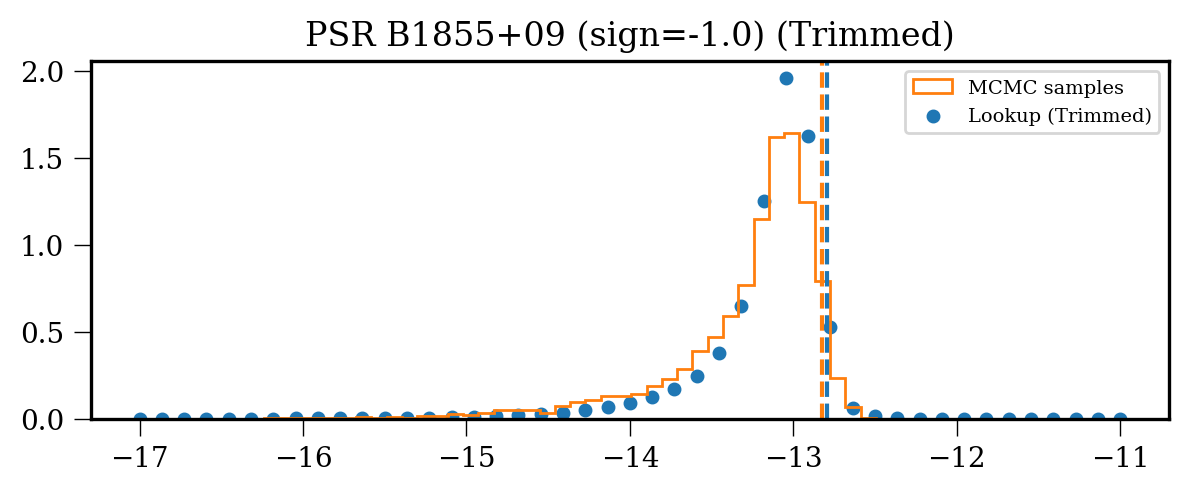

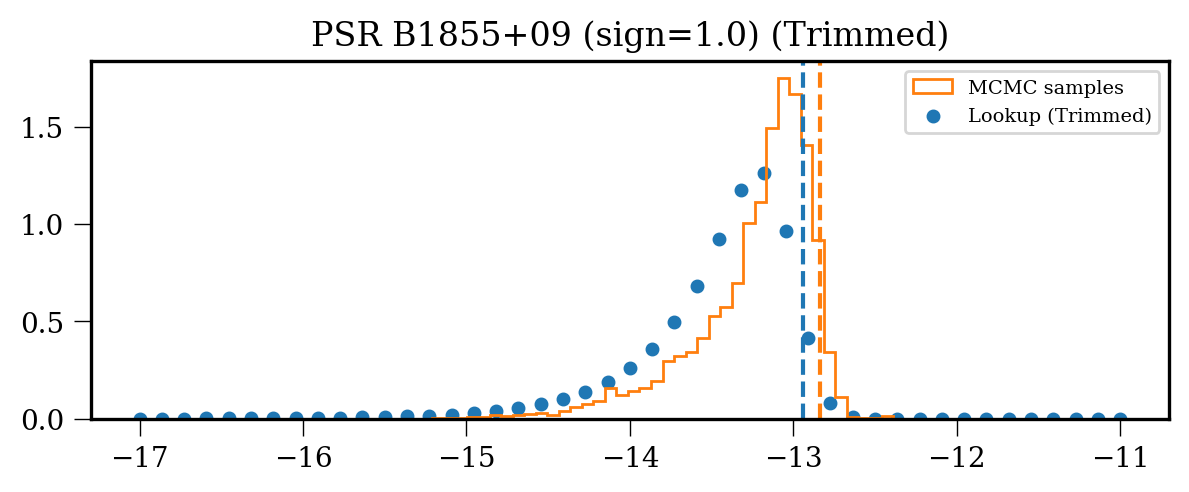

not looking for bursts between MJD 53293.0 and MJD 57894.0


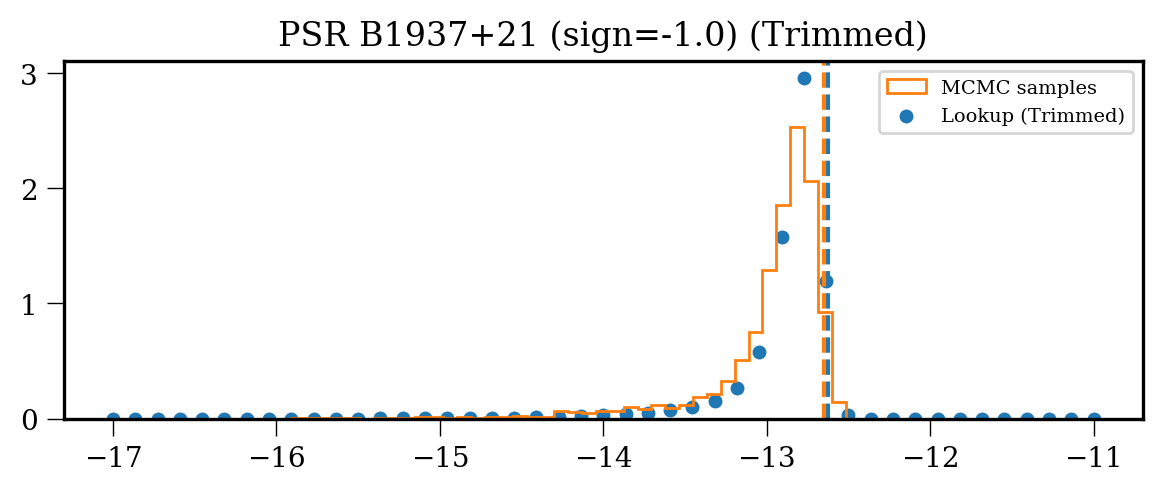

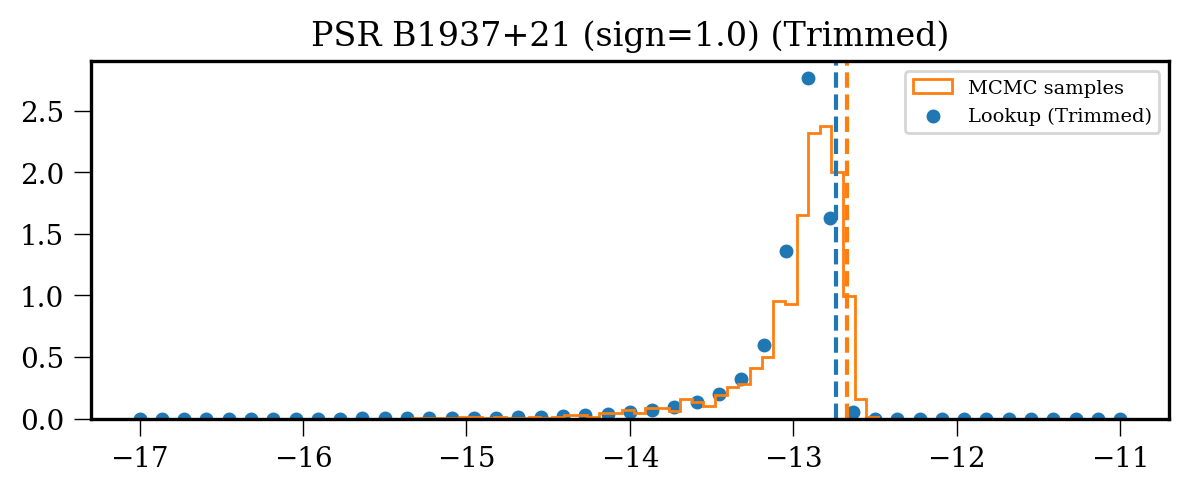

In [35]:
for psr in allpsrs[:2]:
    lookup_resampler_choose(psr, highres=False, trim_epoch=True)

not looking for bursts between MJD 53538.72366848987 and MJD 53448.0


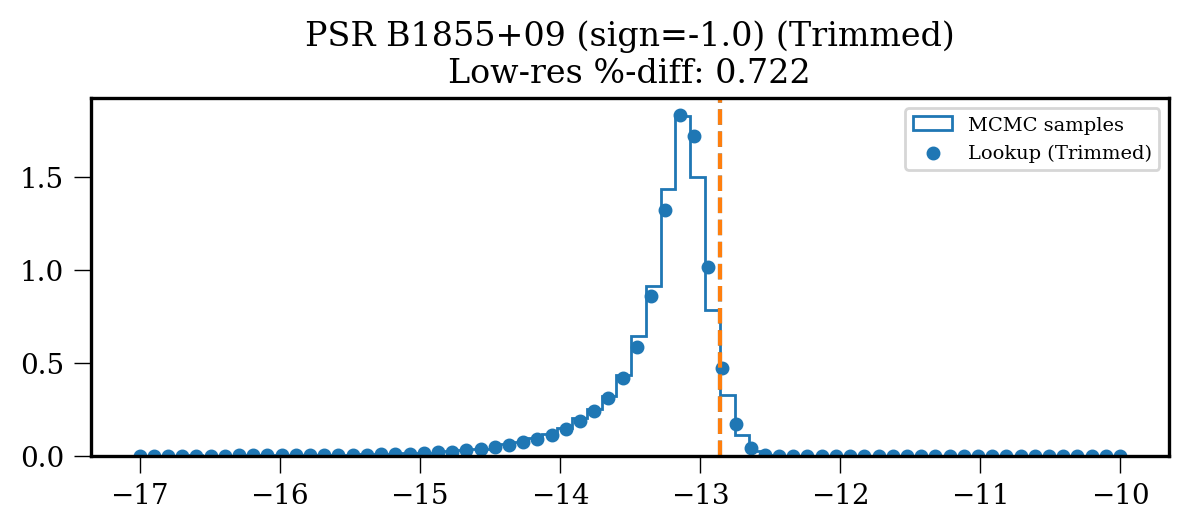

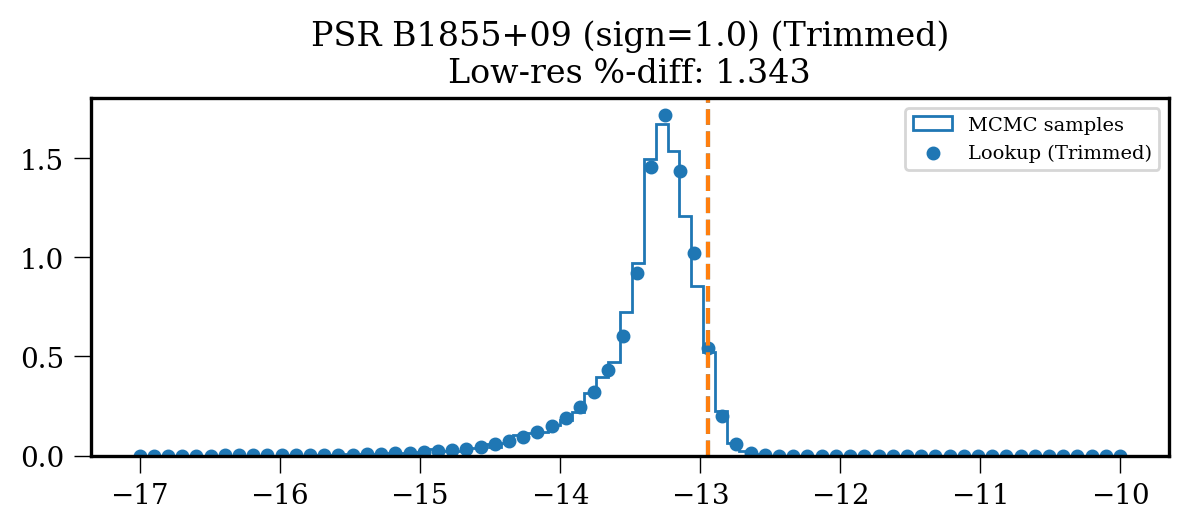

not looking for bursts between MJD 53447.08924884693 and MJD 53293.0


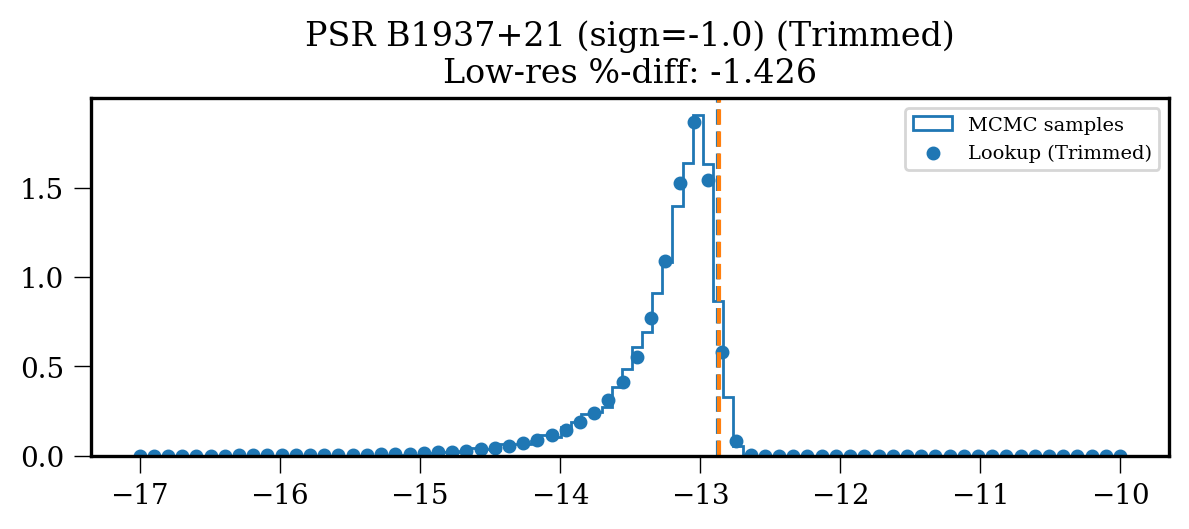

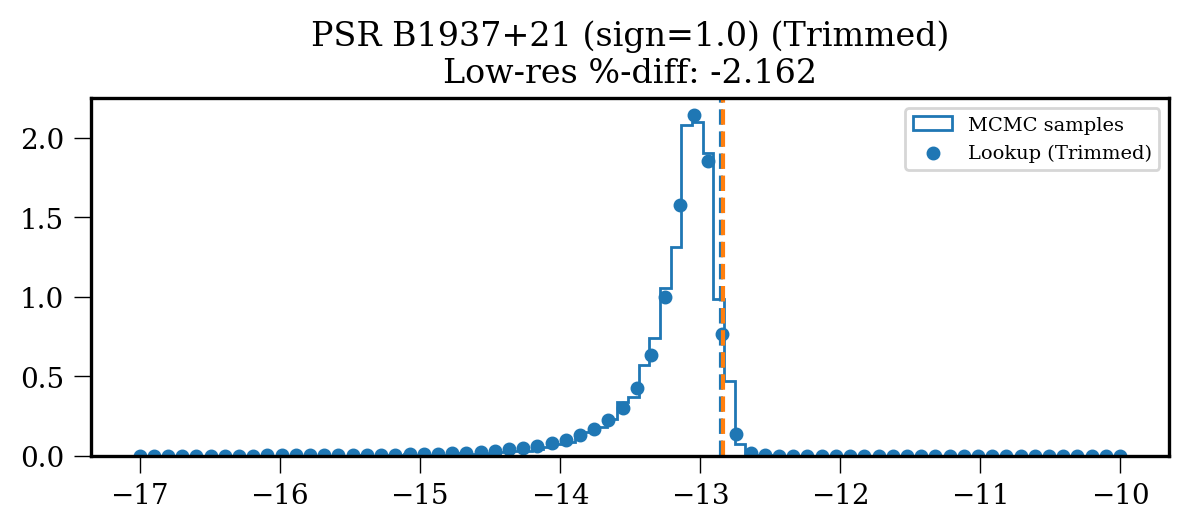

not looking for bursts between MJD 55940.22822341733 and MJD 55911.0


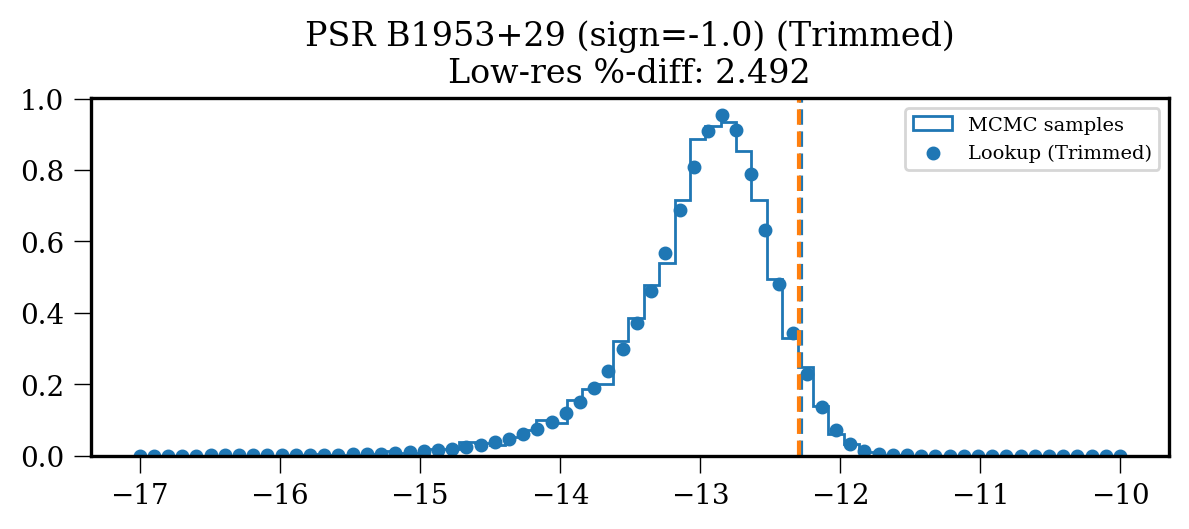

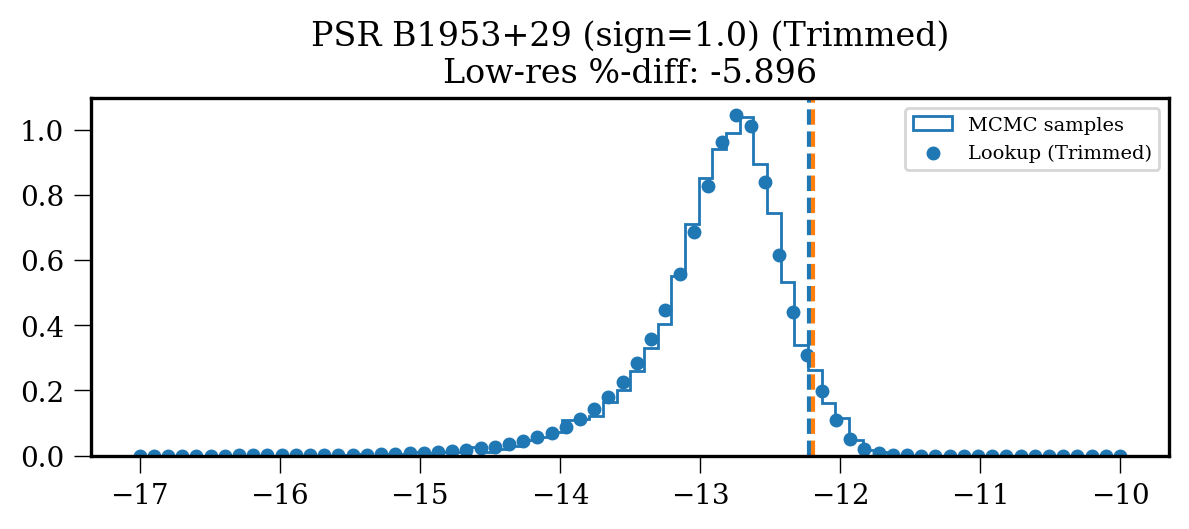

not looking for bursts between MJD 55938.347792841676 and MJD 55789.0


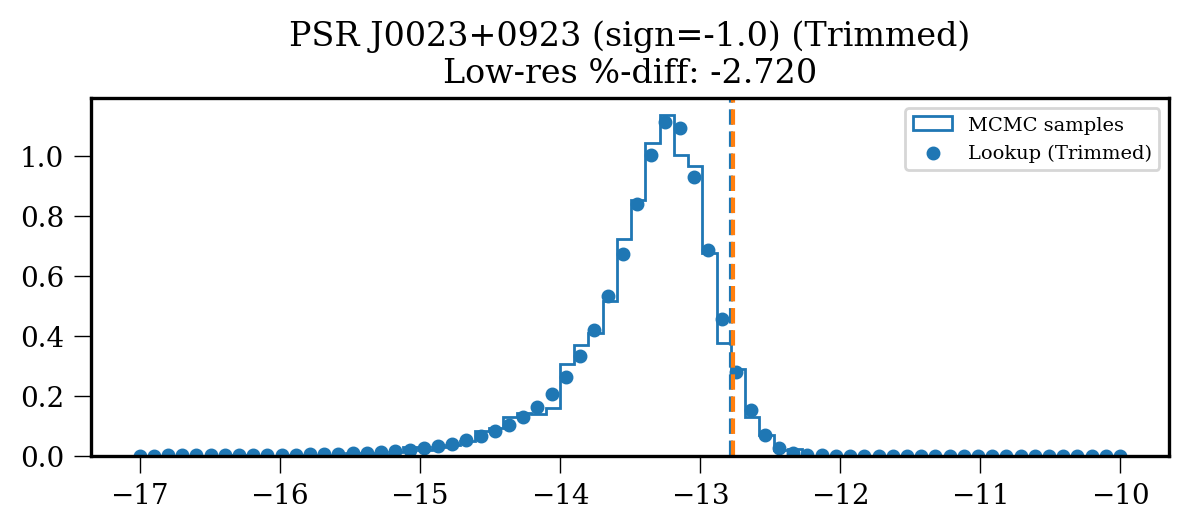

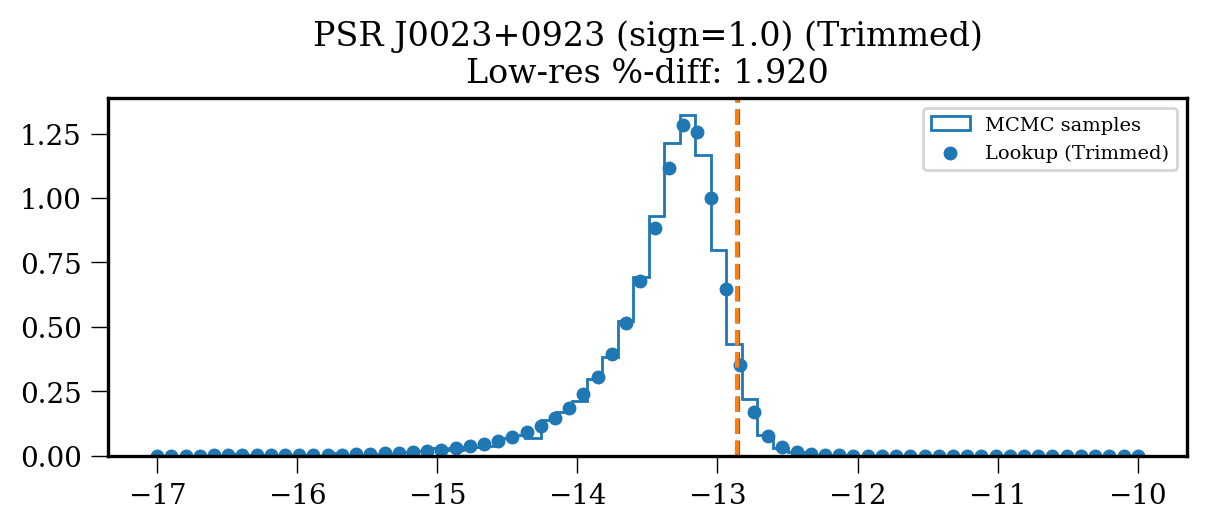

not looking for bursts between MJD 53574.85366135469 and MJD 53532.0


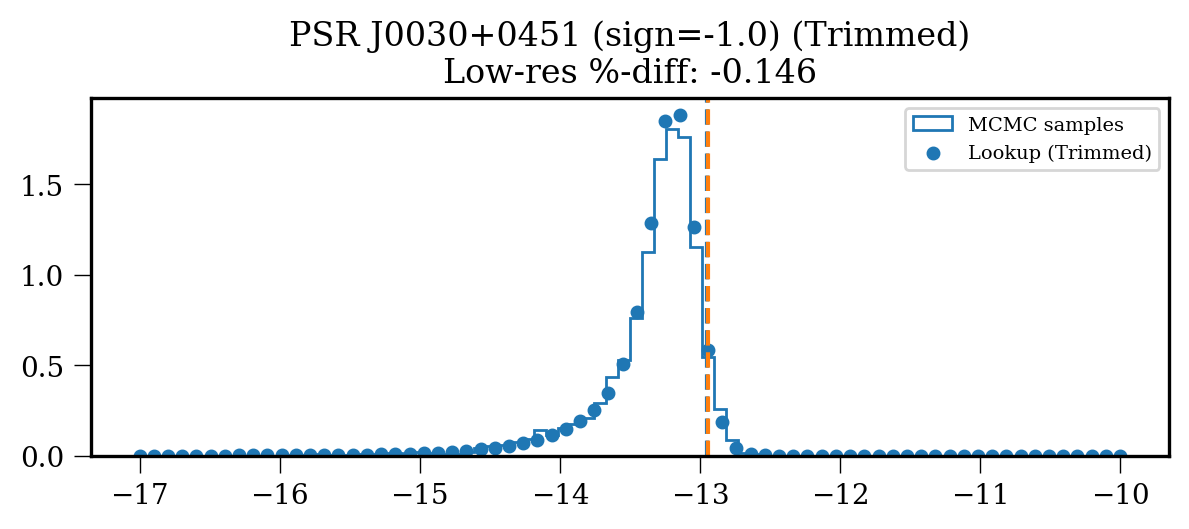

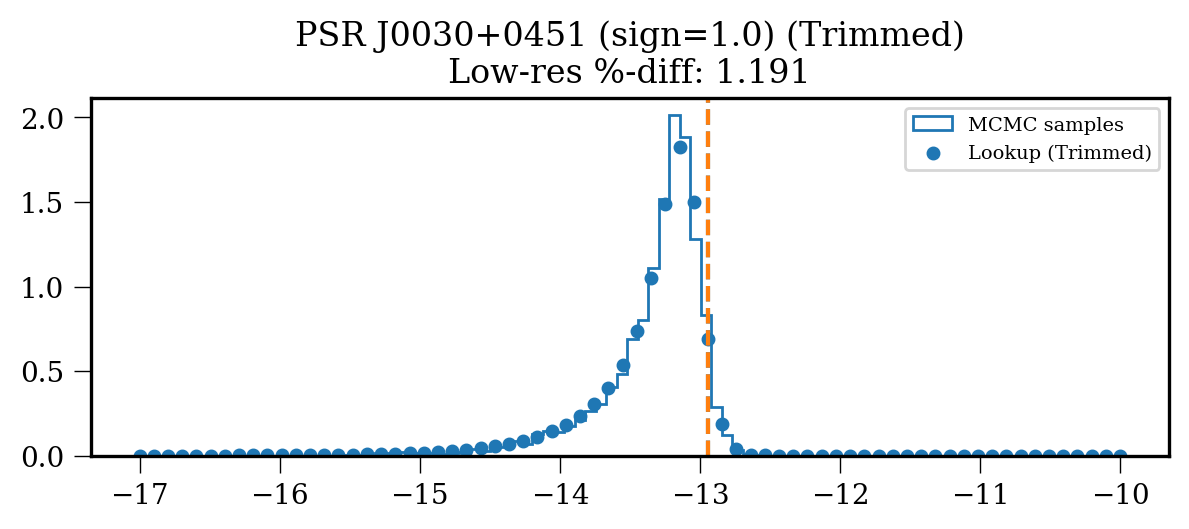

not looking for bursts between MJD 56152.08141259022 and MJD 56065.0


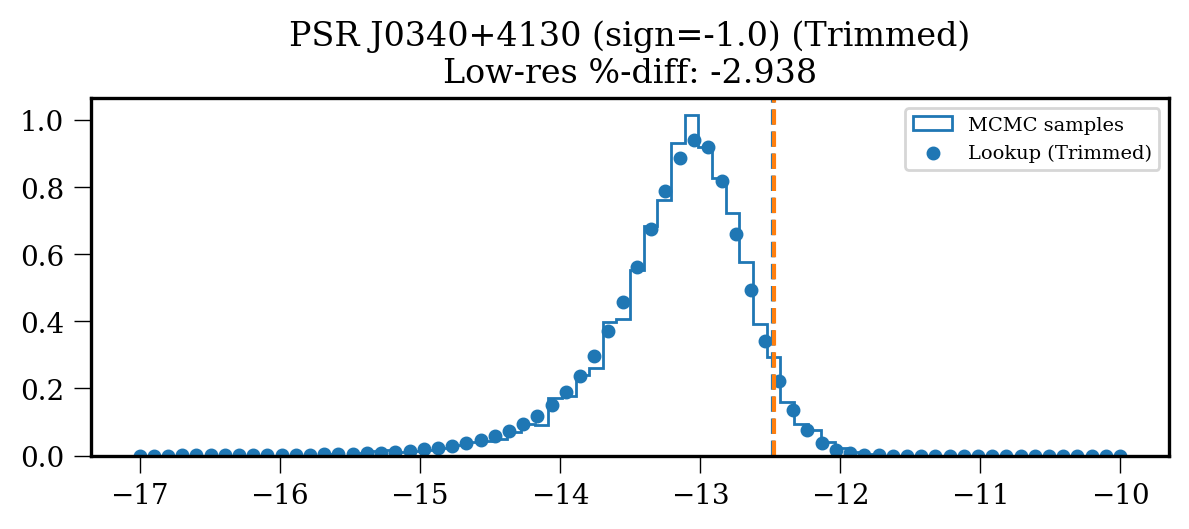

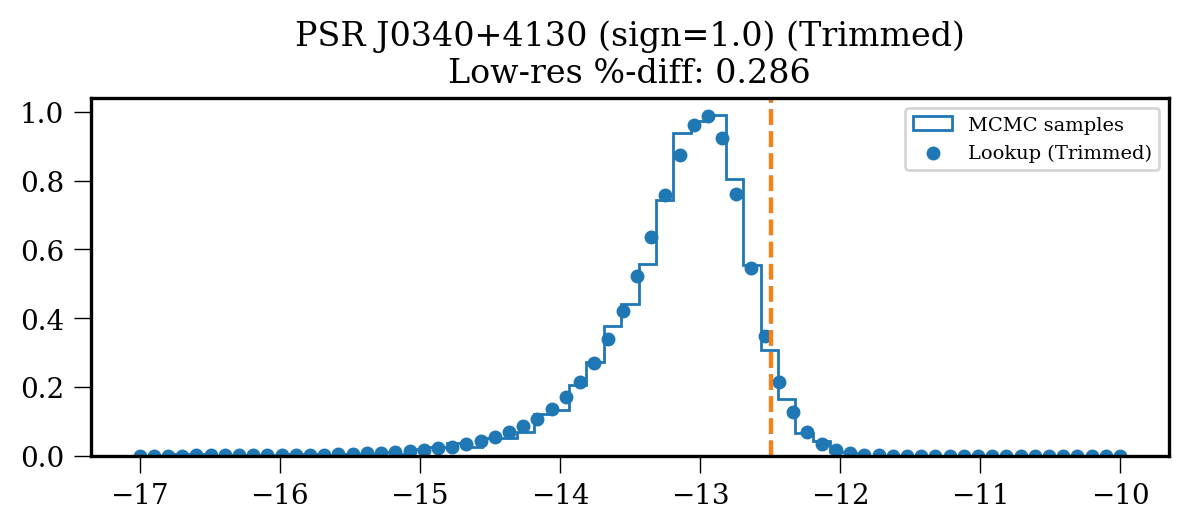

not looking for bursts between MJD 53628.79472384466 and MJD 53450.0


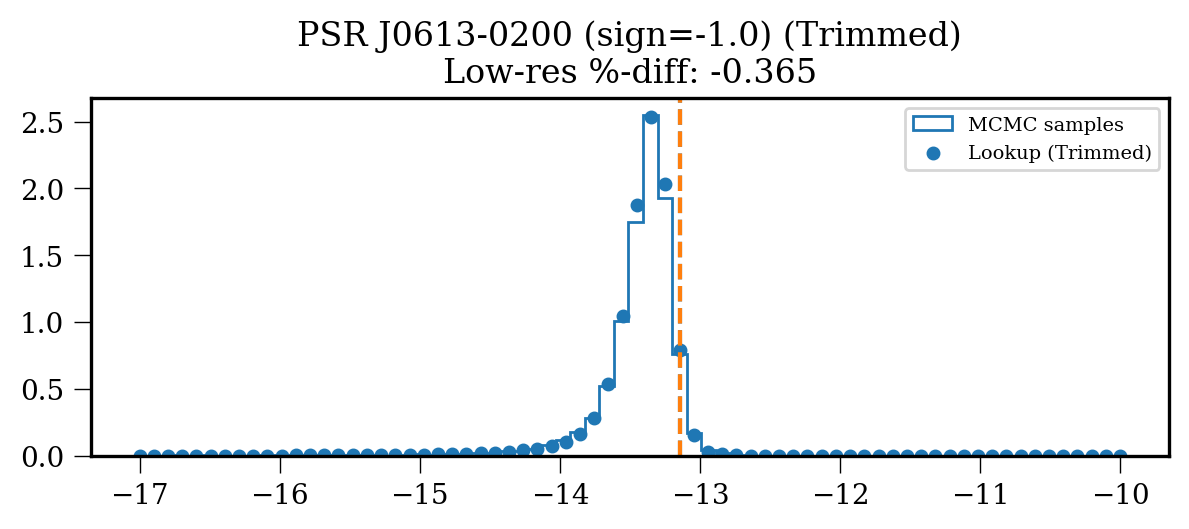

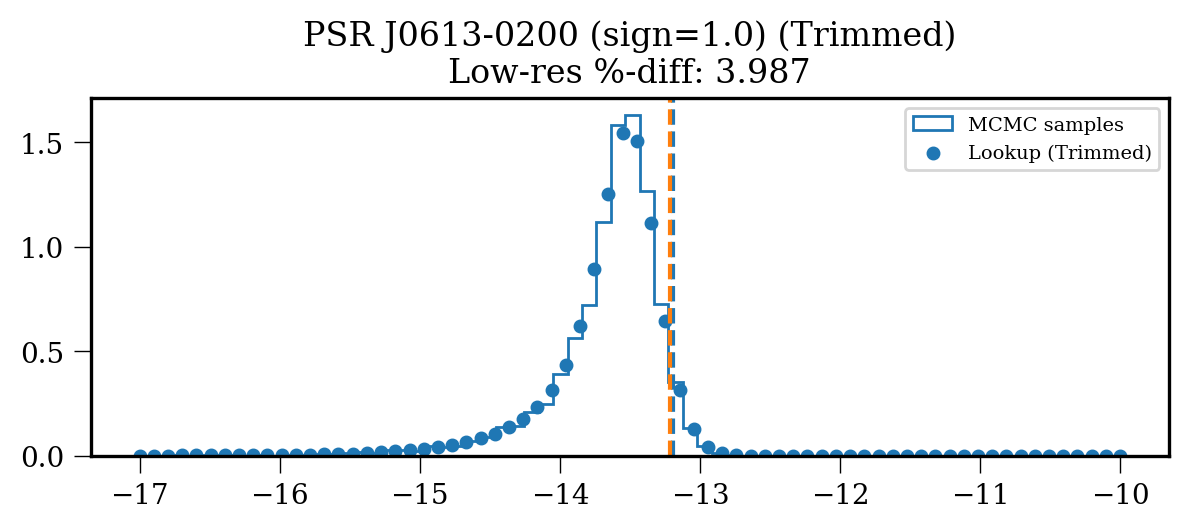

not looking for bursts between MJD 55884.04062376582 and MJD 55948.0


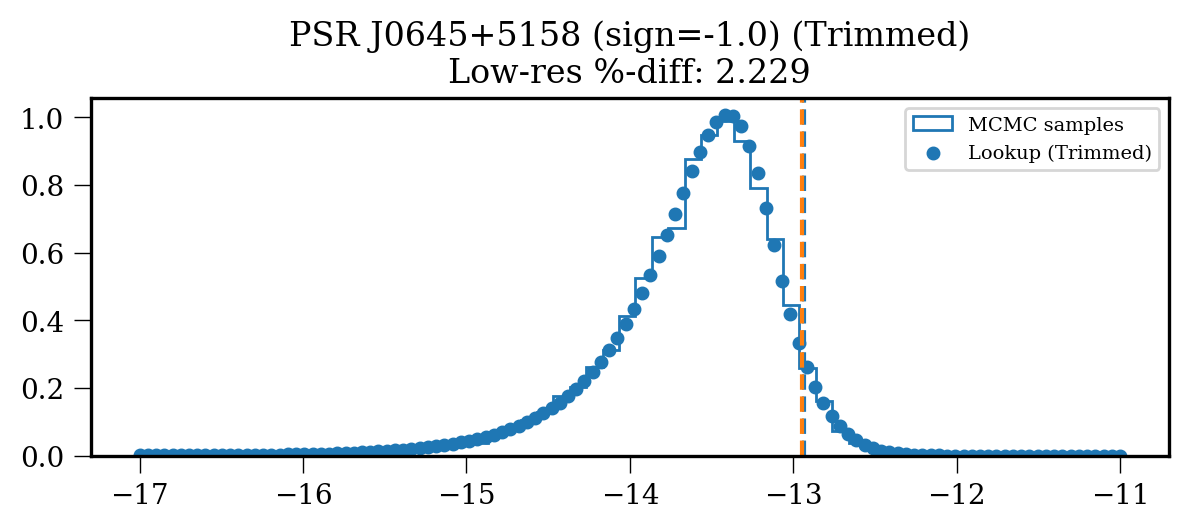

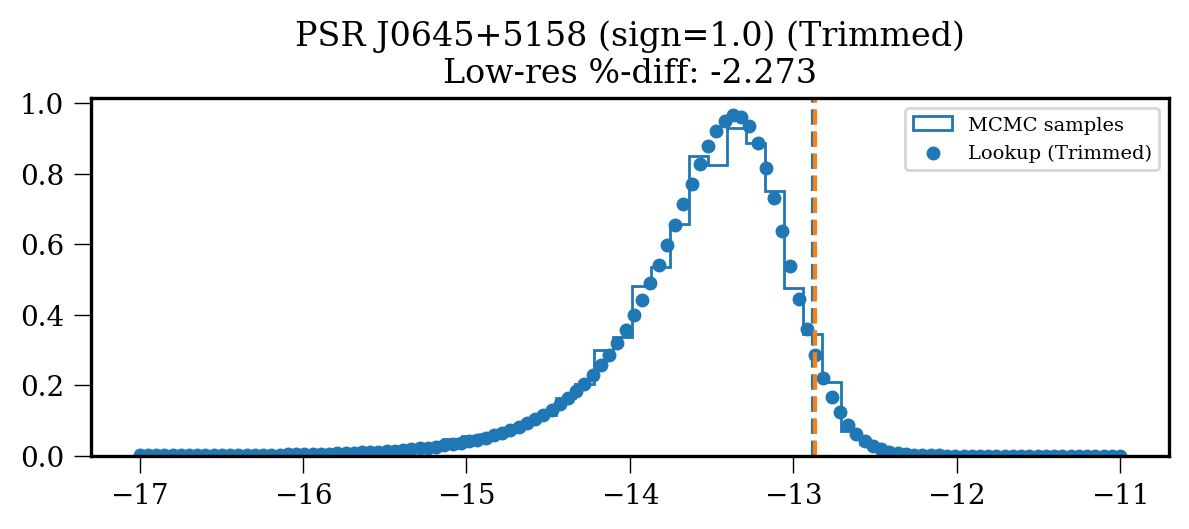

not looking for bursts between MJD 53397.58856976554 and MJD 53267.0


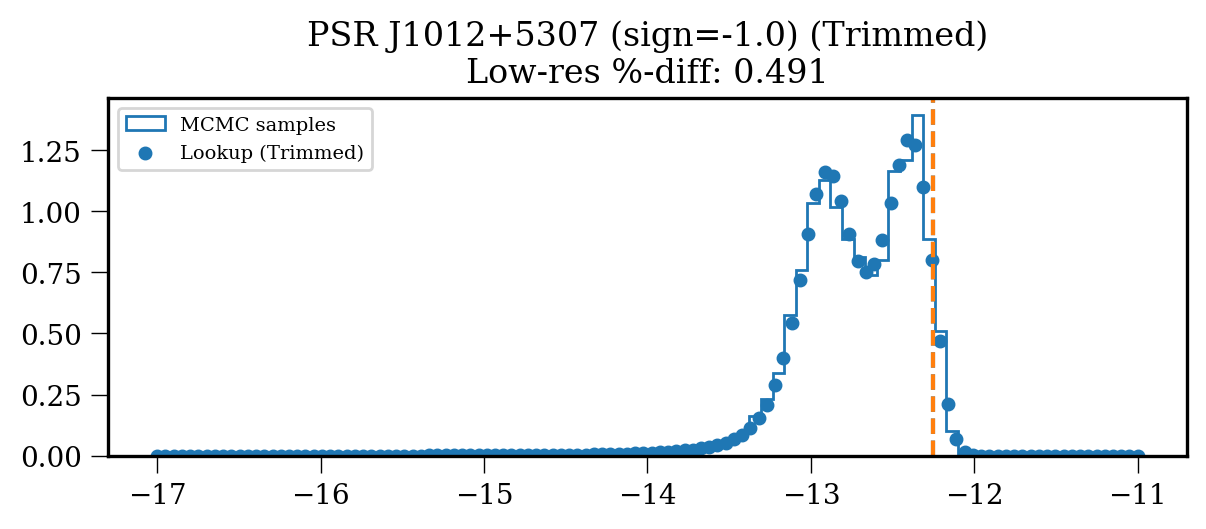

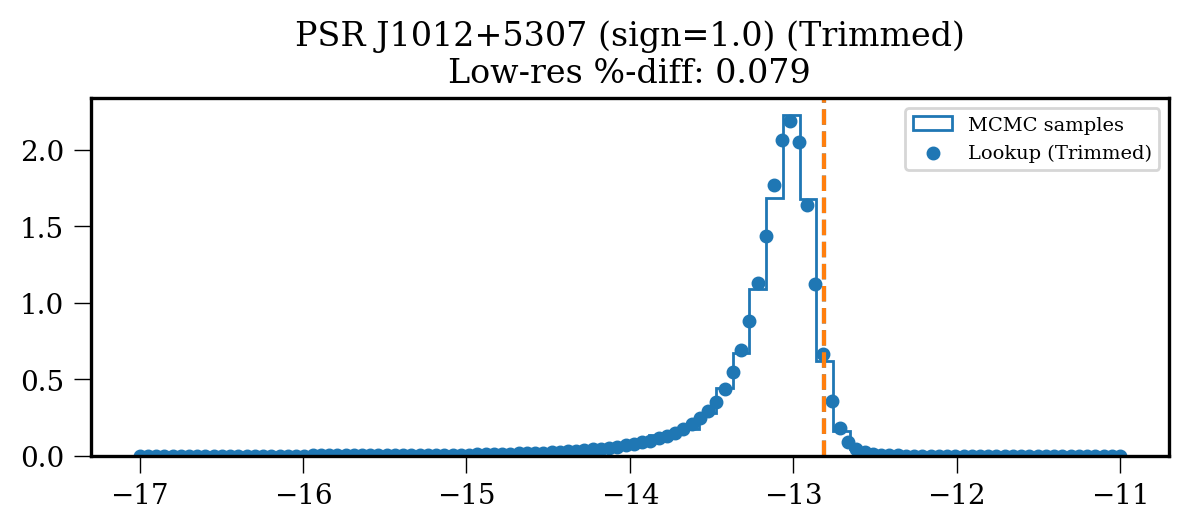

not looking for bursts between MJD 55298.58422232041 and MJD 55305.0


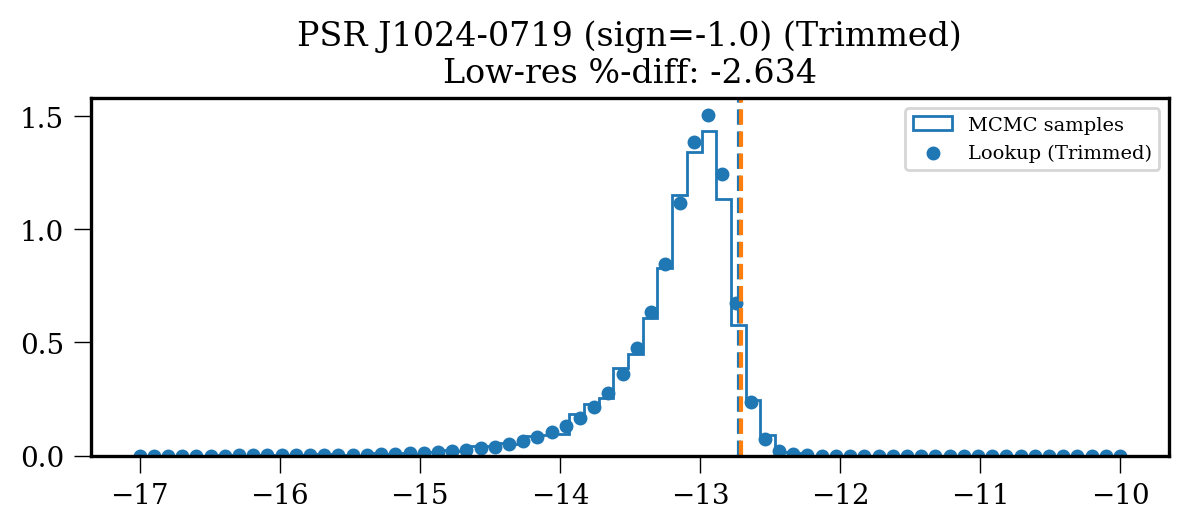

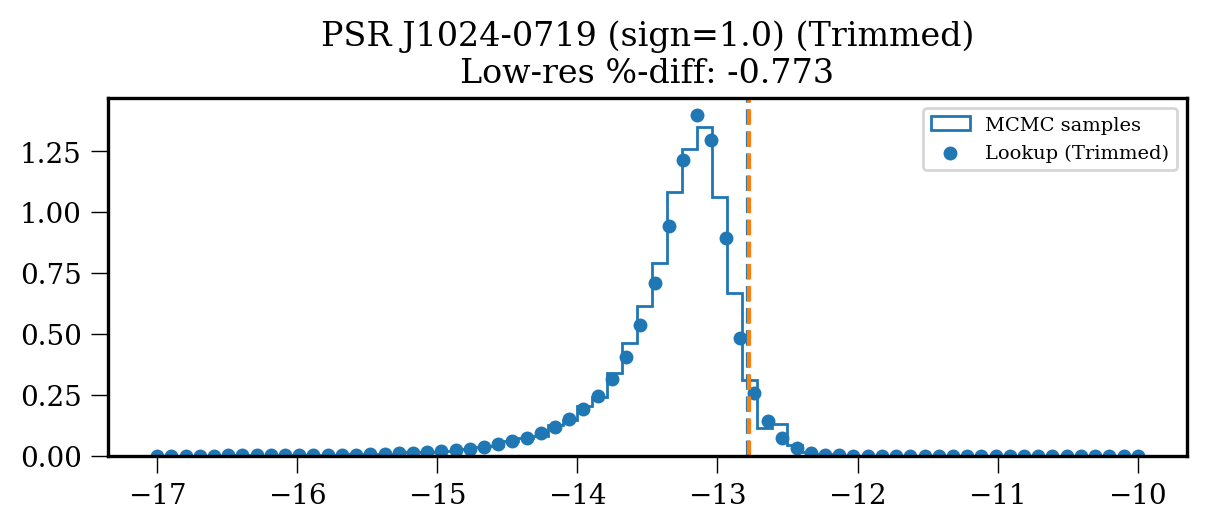

not looking for bursts between MJD 53397.01097847137 and MJD 53693.0


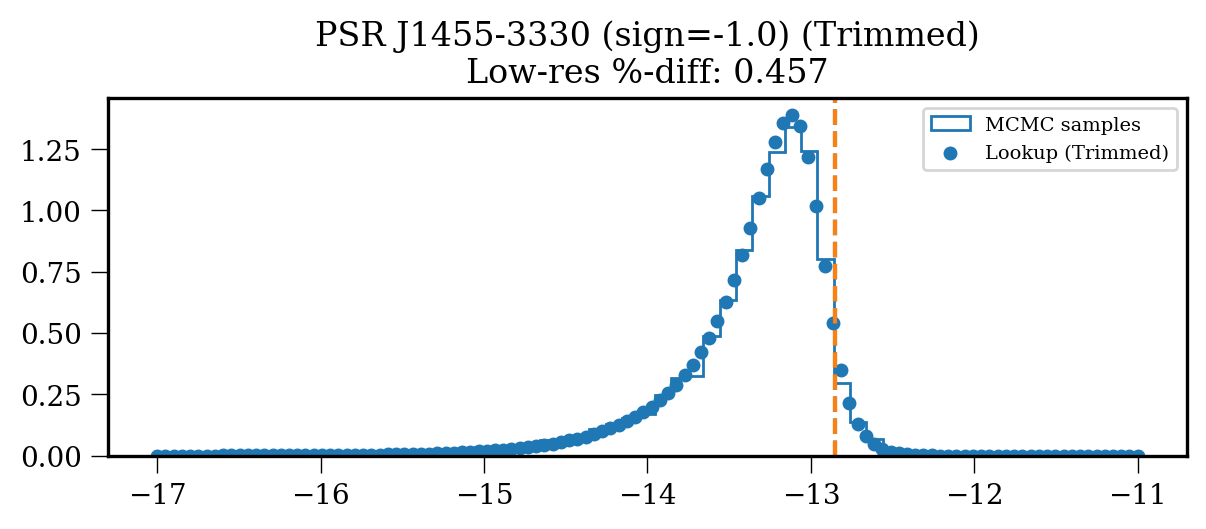

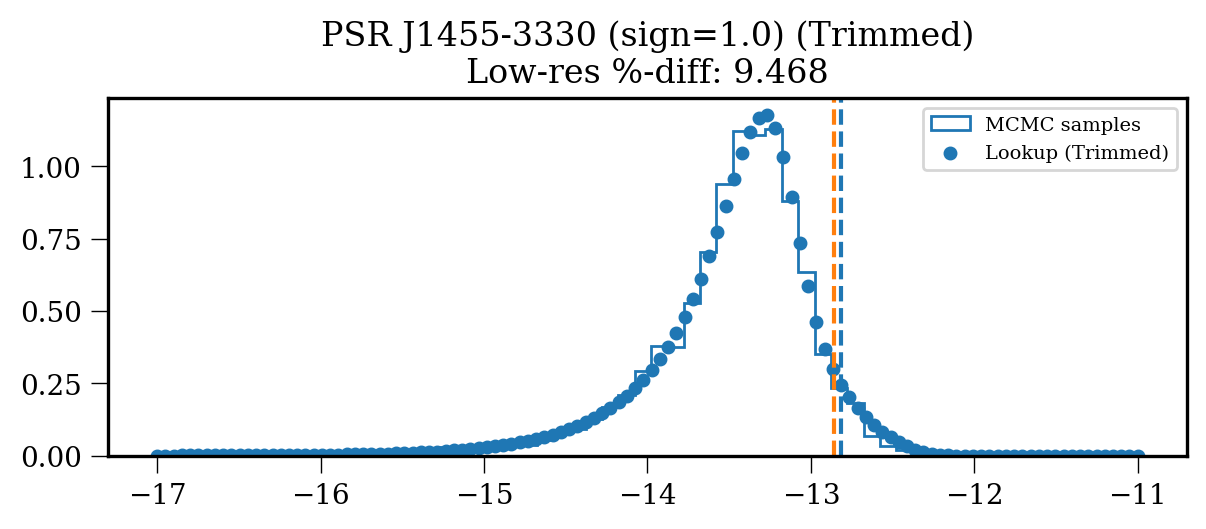

not looking for bursts between MJD 54580.655653609945 and MJD 54552.0


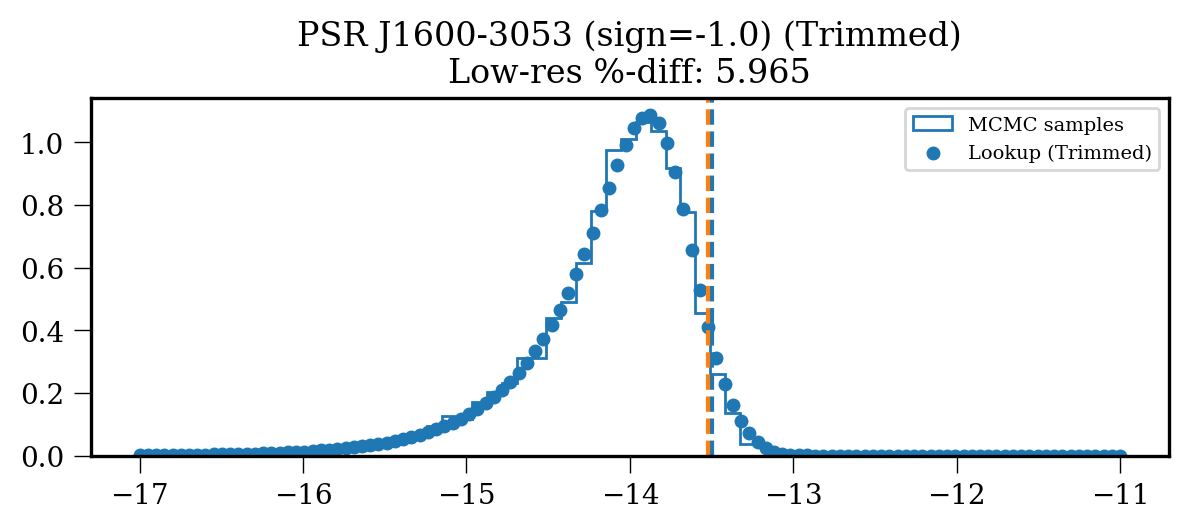

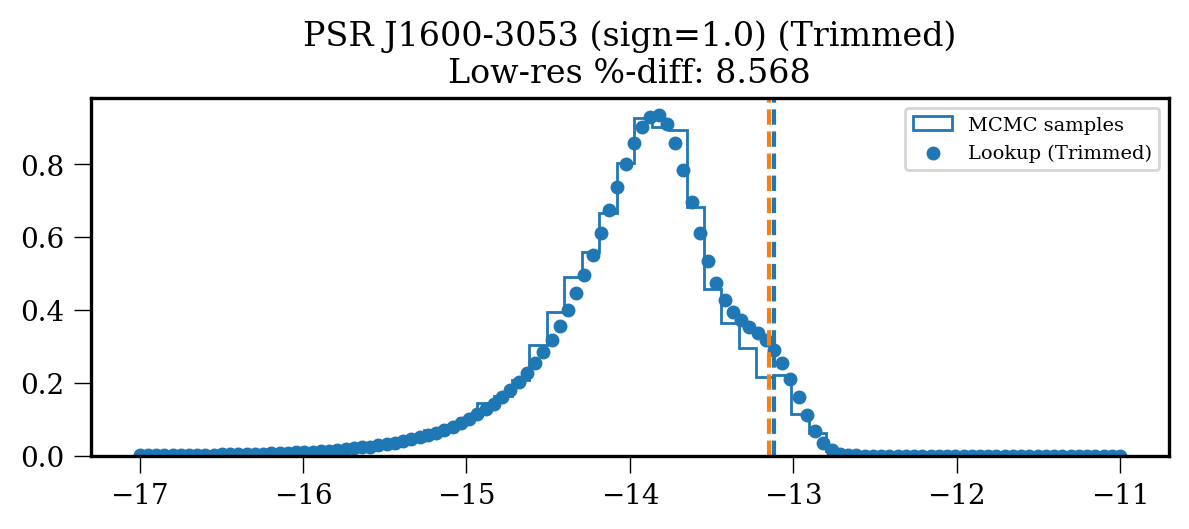

not looking for bursts between MJD 54904.87287711698 and MJD 55214.0


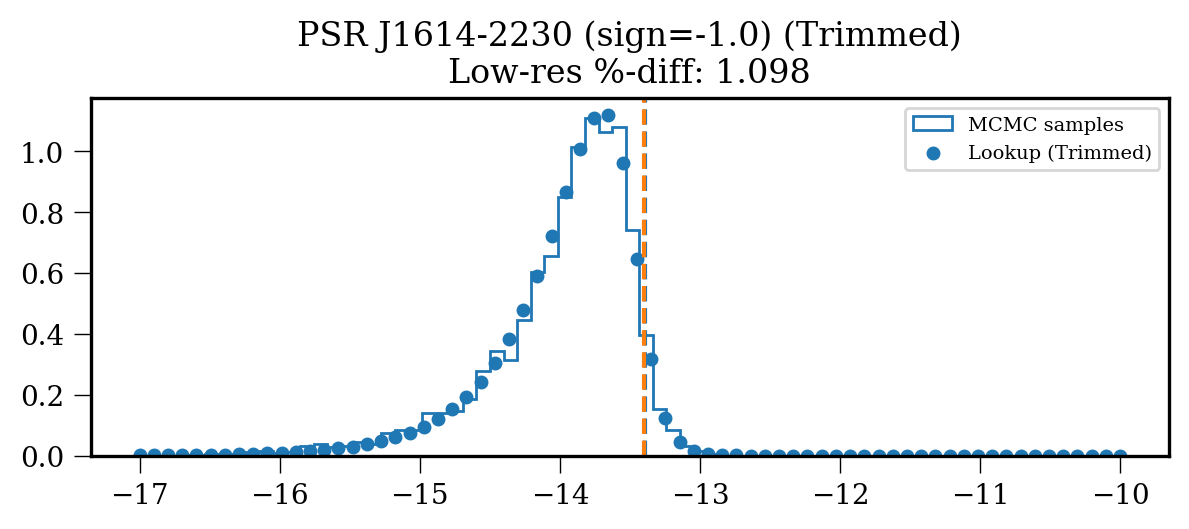

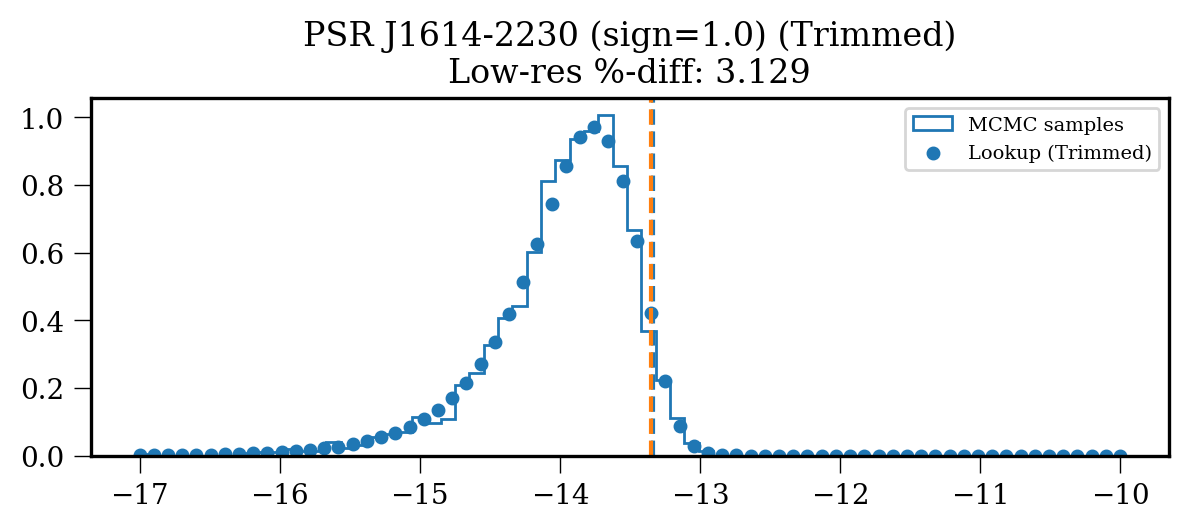

not looking for bursts between MJD 53524.6351316123 and MJD 53420.0


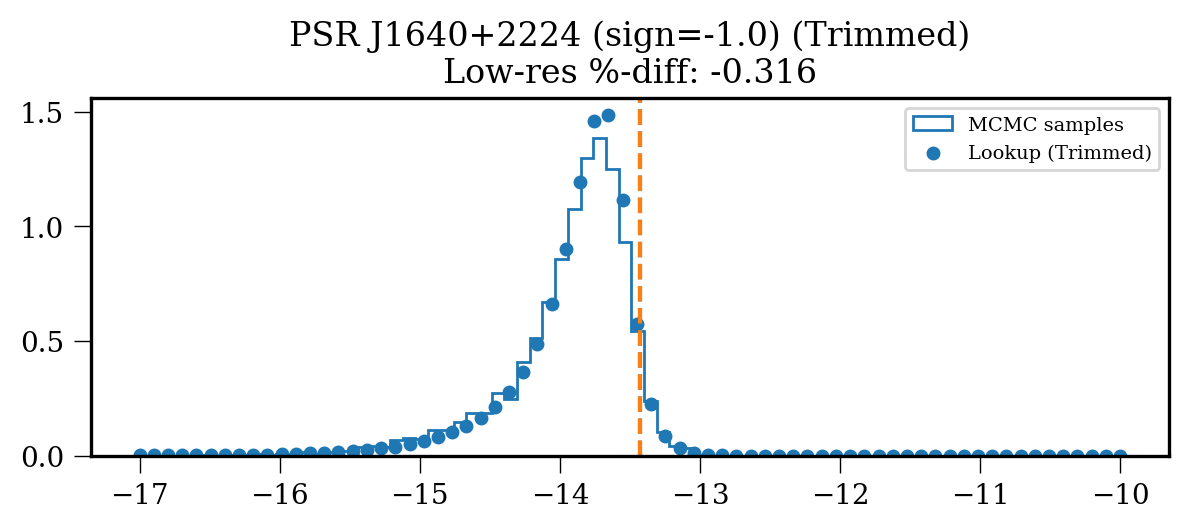

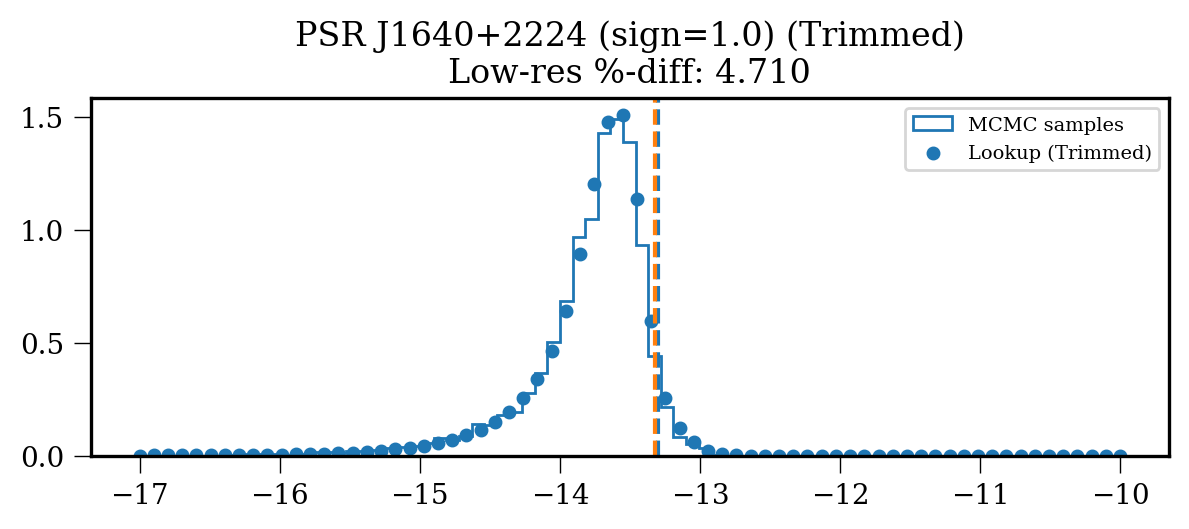

not looking for bursts between MJD 53471.906175769946 and MJD 53450.0


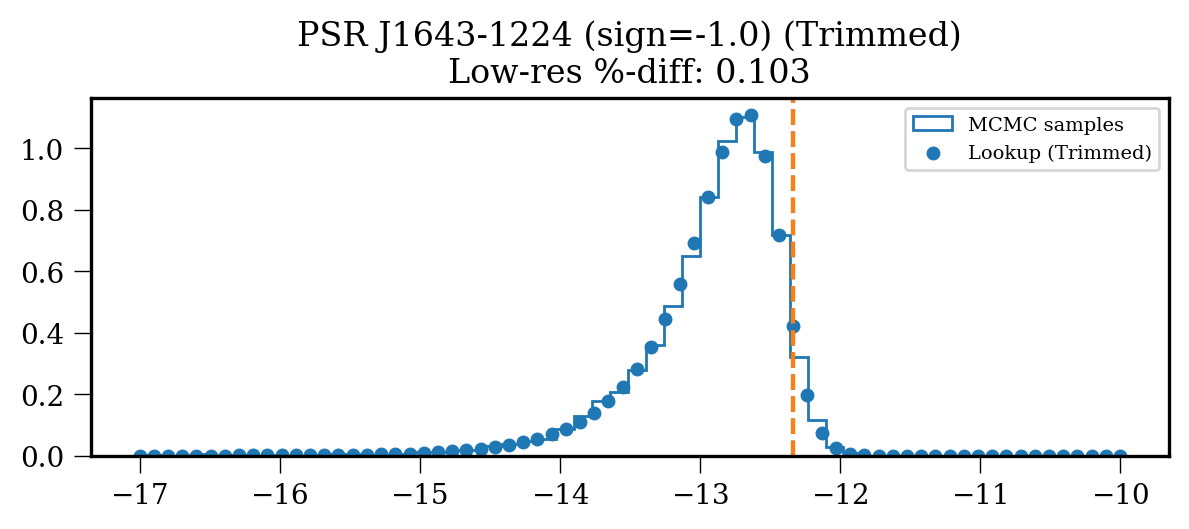

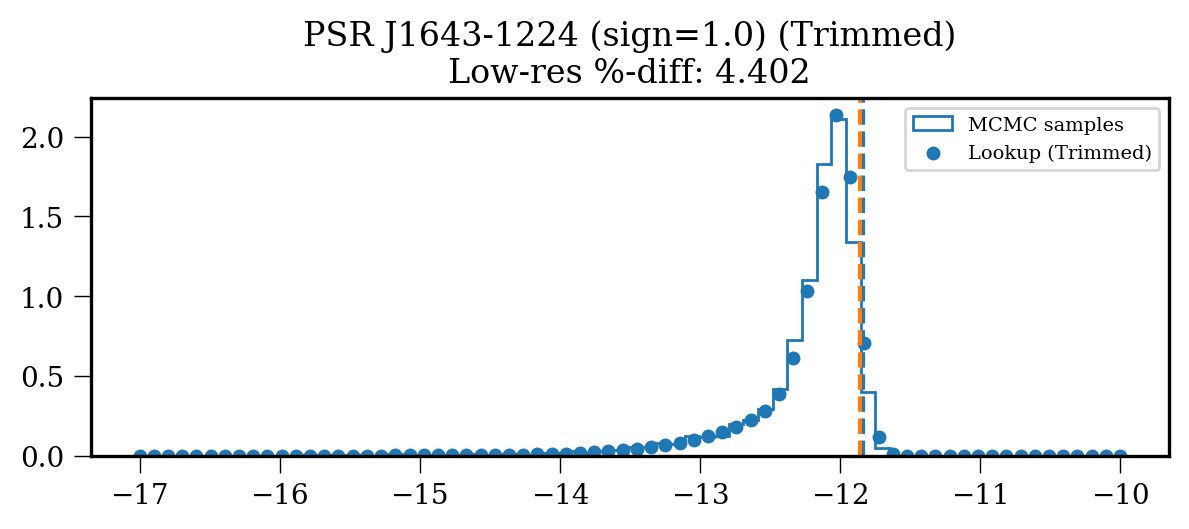

not looking for bursts between MJD 53573.558782884036 and MJD 53448.0


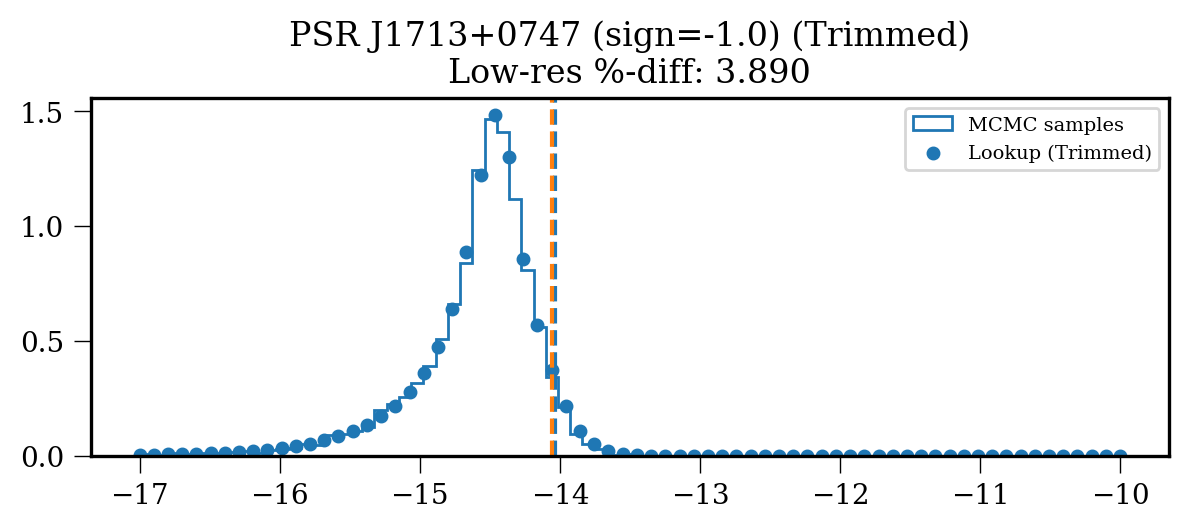

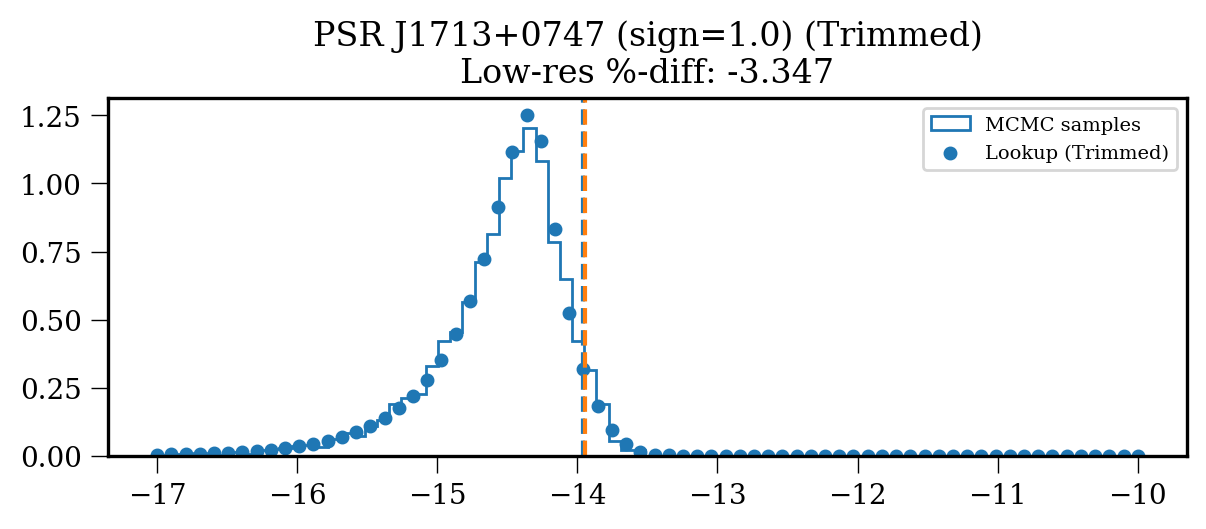

not looking for bursts between MJD 55315.795944946985 and MJD 55638.0


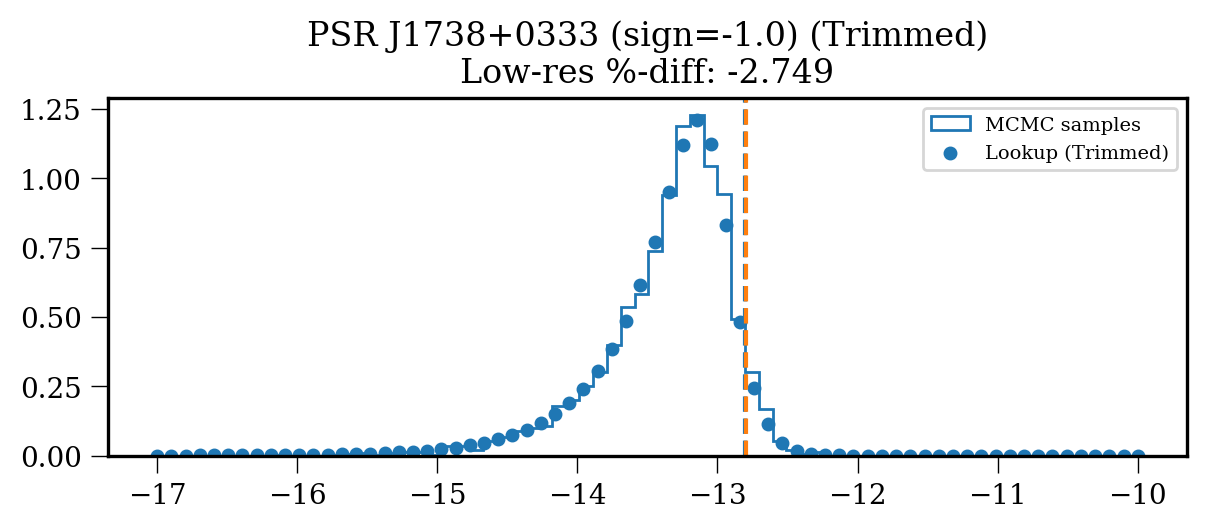

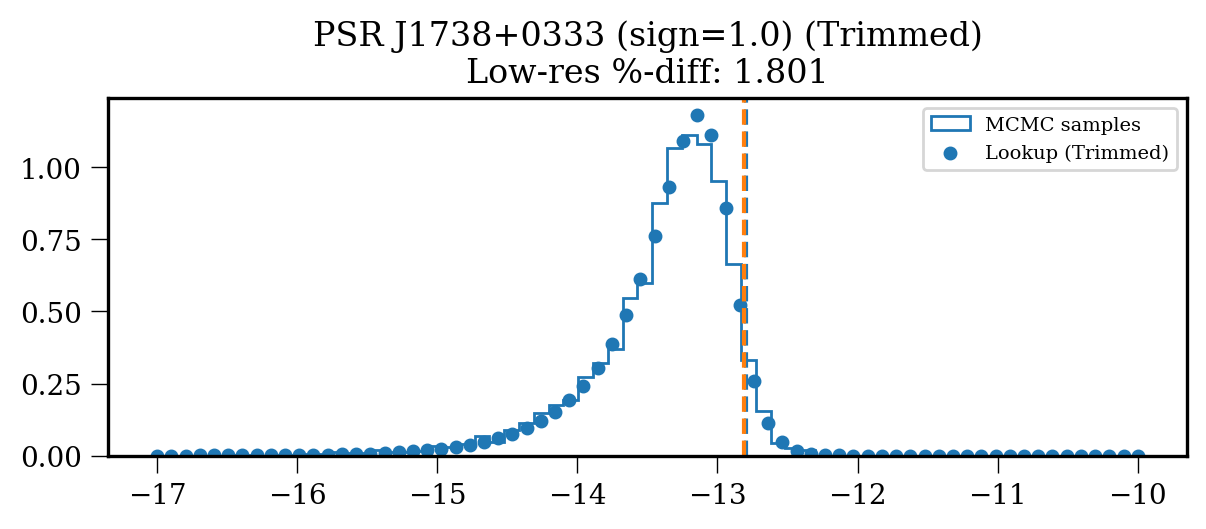

not looking for bursts between MJD 55222.047012554416 and MJD 55206.0


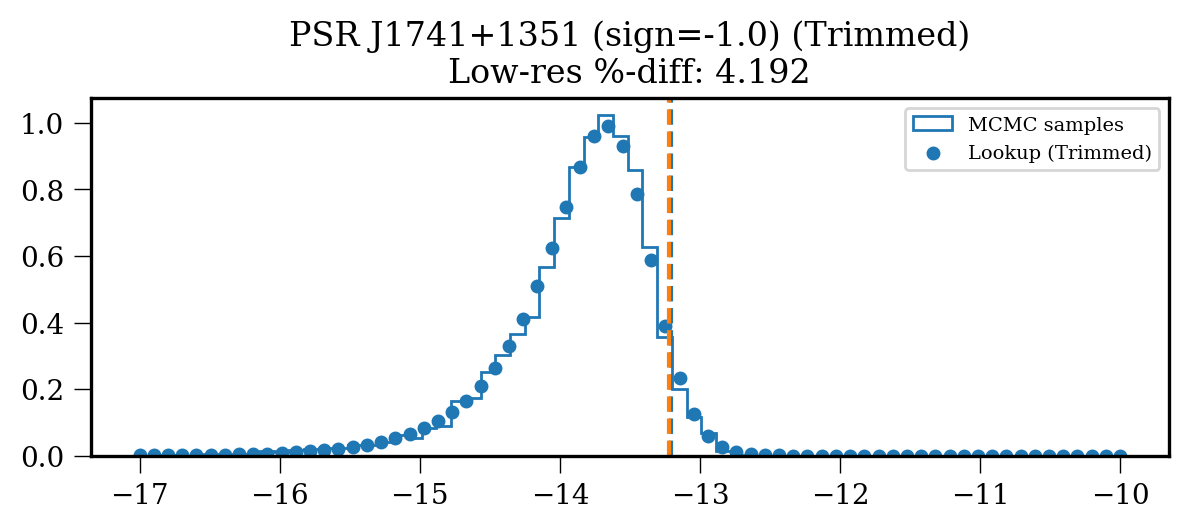

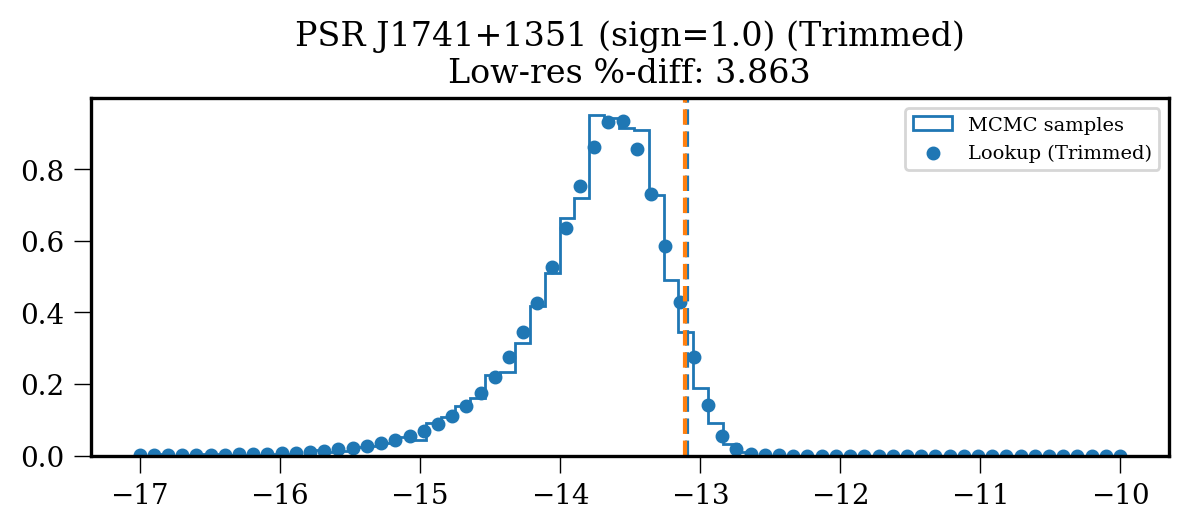

not looking for bursts between MJD 53396.13175403874 and MJD 53694.0


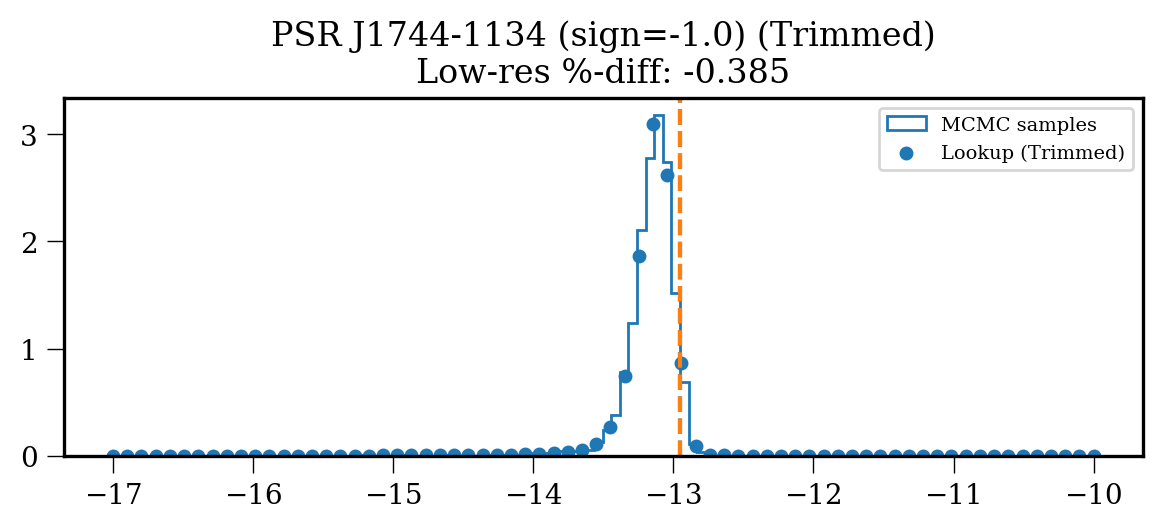

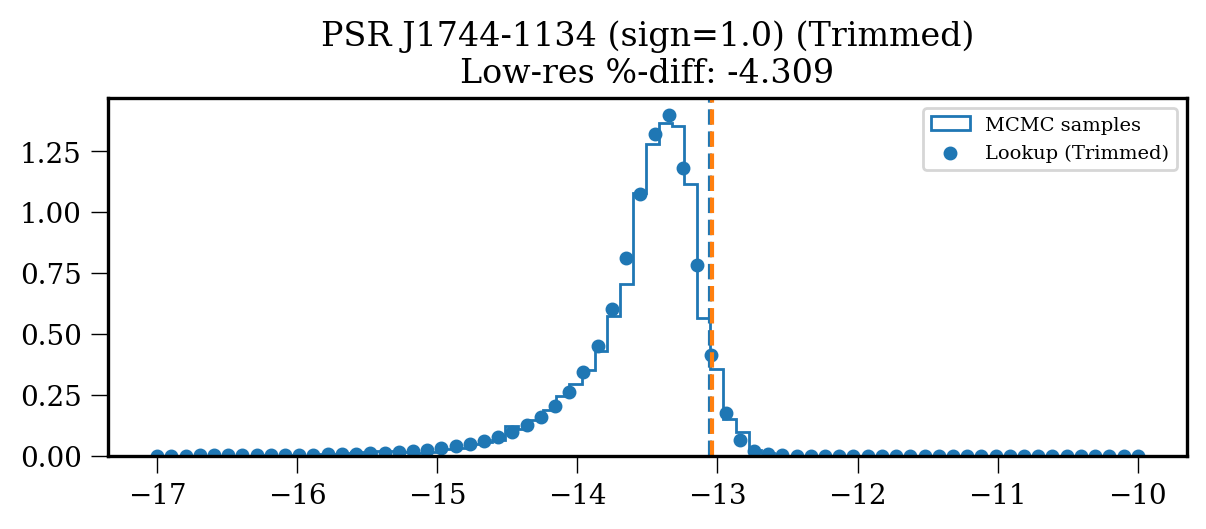

not looking for bursts between MJD 56156.54901506683 and MJD 56095.0


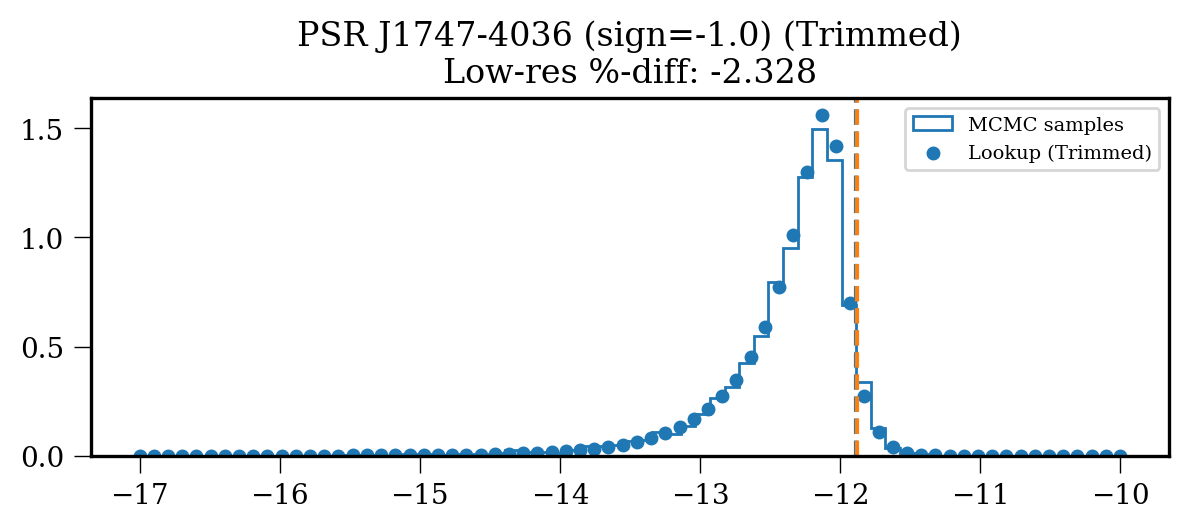

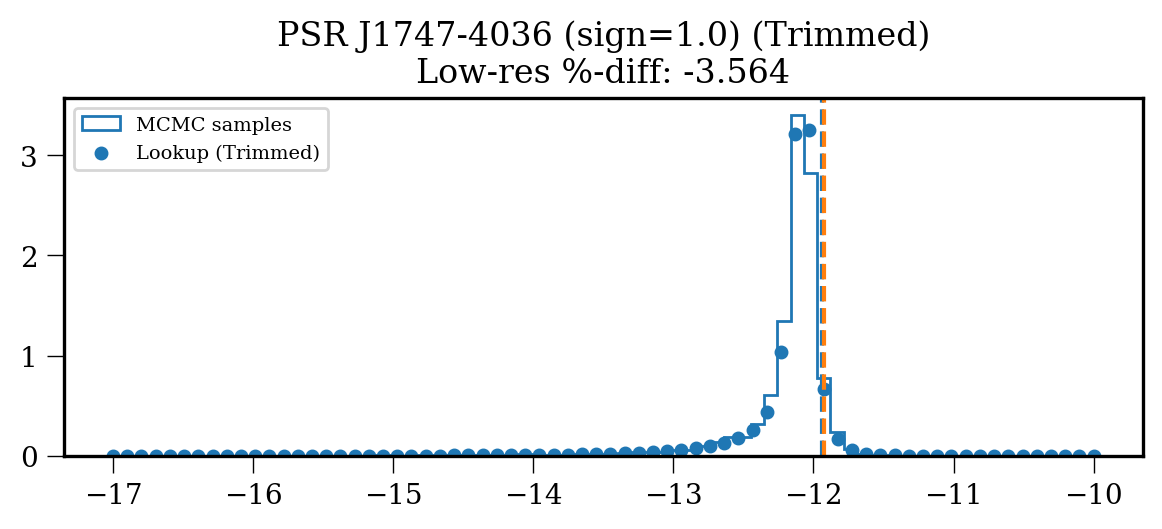

not looking for bursts between MJD 55911.198982493865 and MJD 55912.0


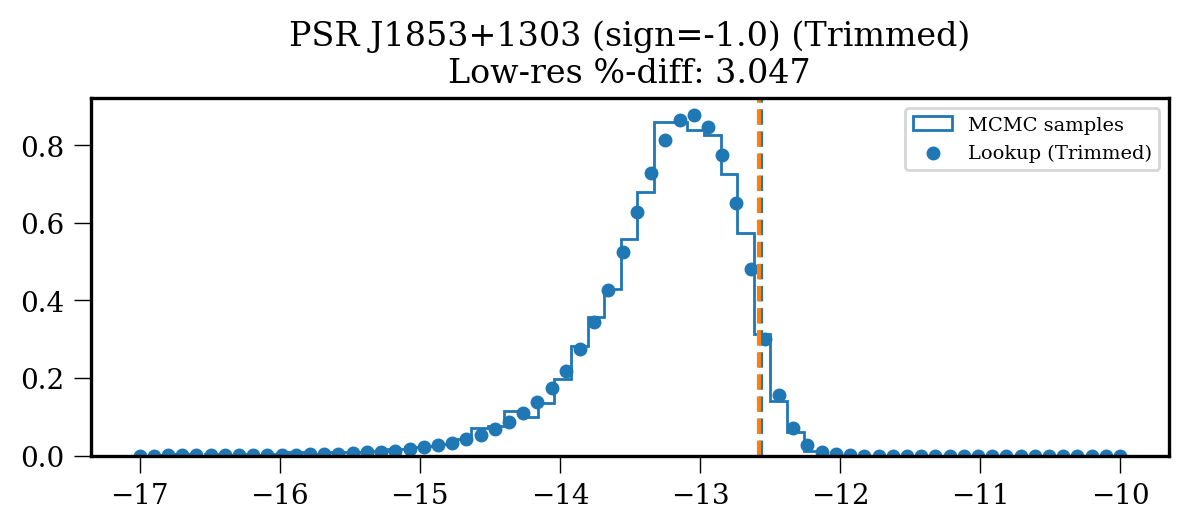

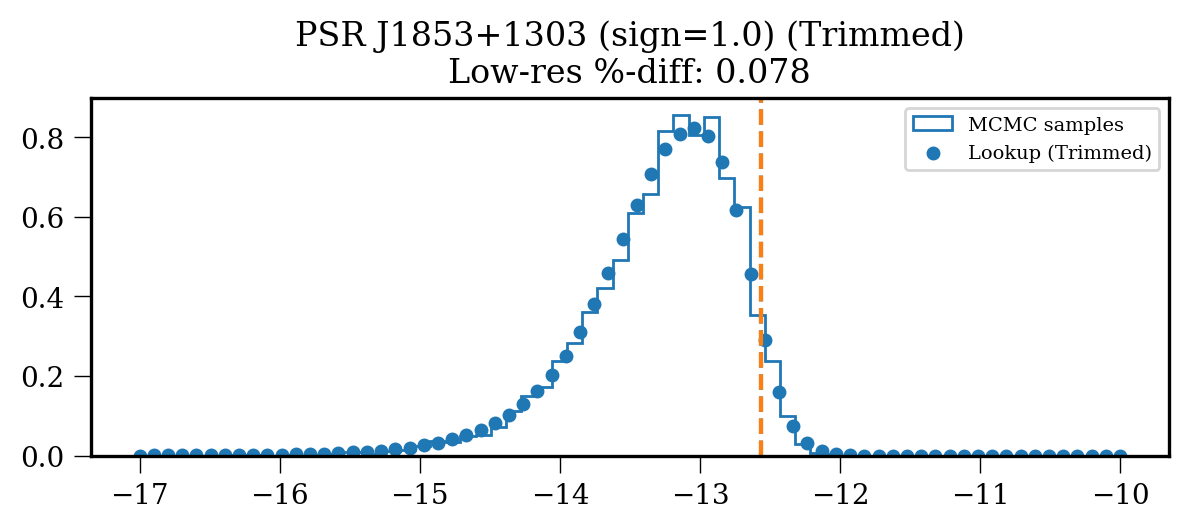

not looking for bursts between MJD 55315.87690421579 and MJD 55638.0


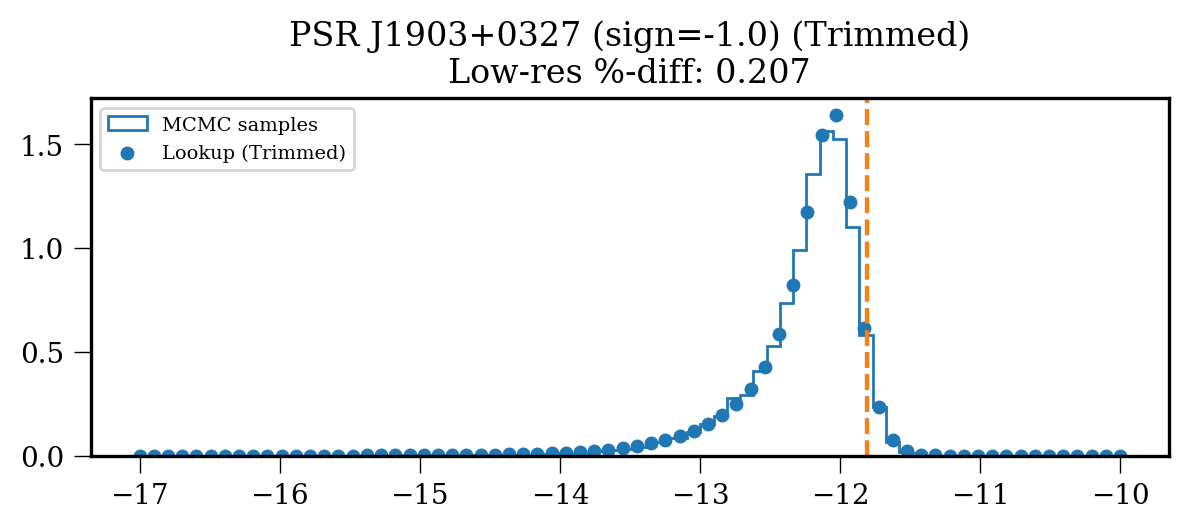

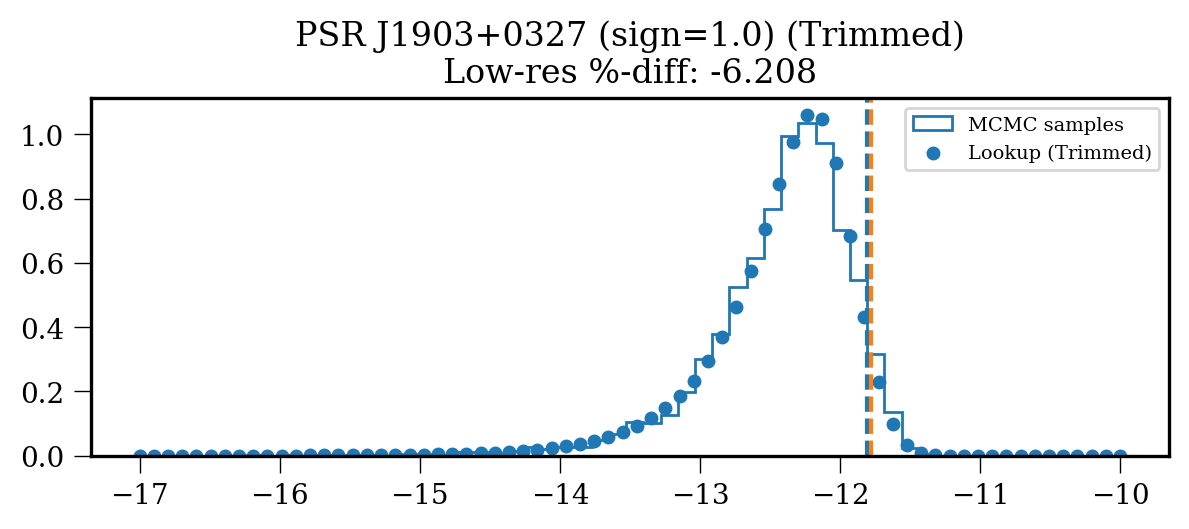

not looking for bursts between MJD 53472.0166380138 and MJD 53839.0


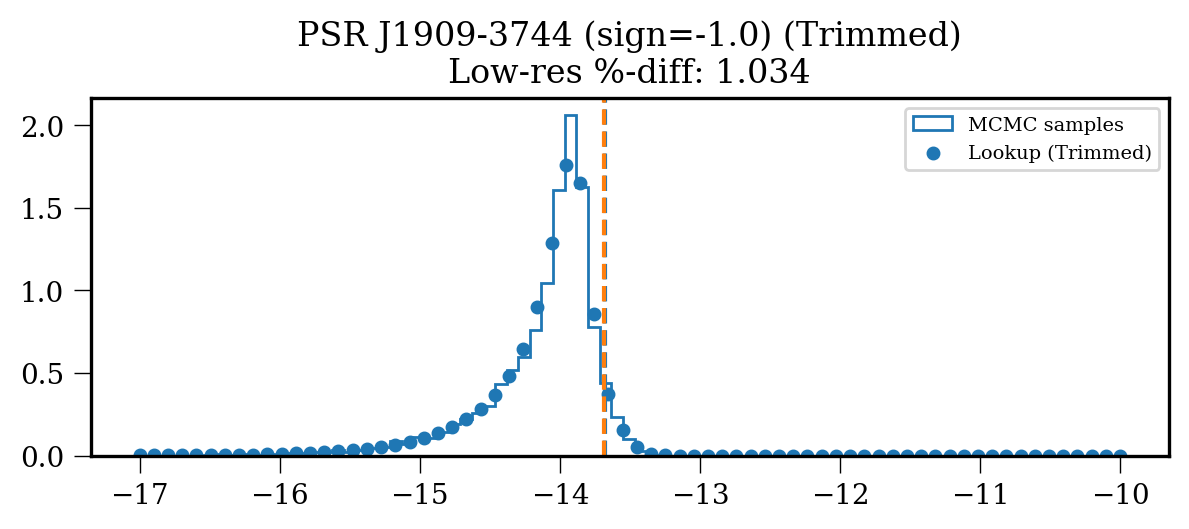

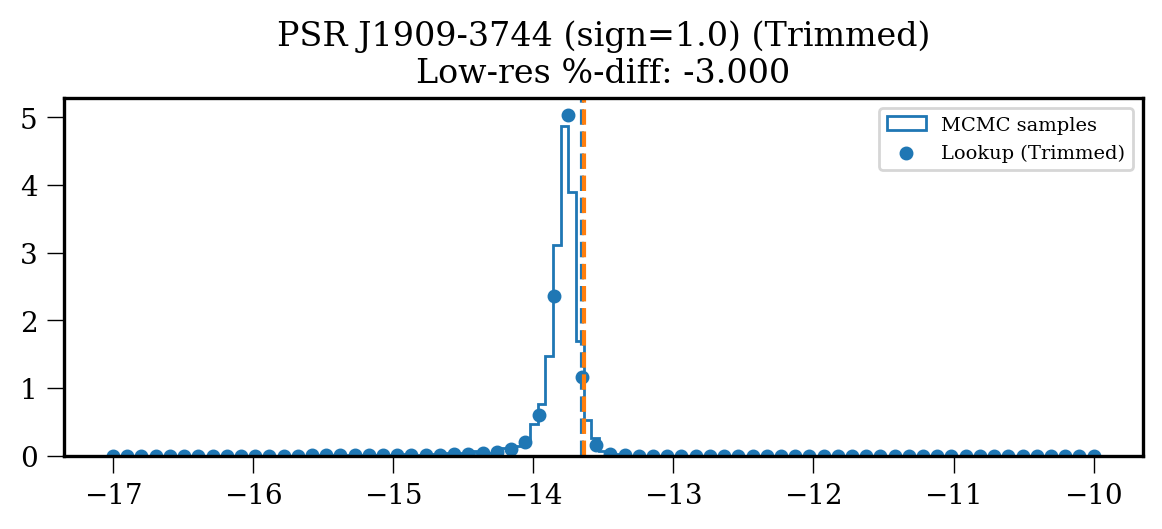

not looking for bursts between MJD 55062.599552313506 and MJD 55087.0


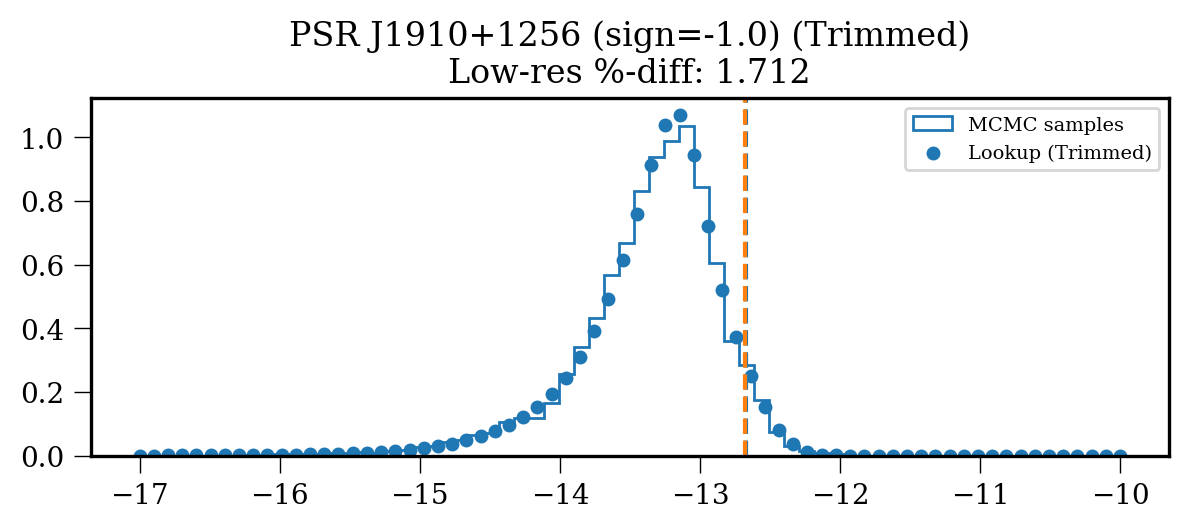

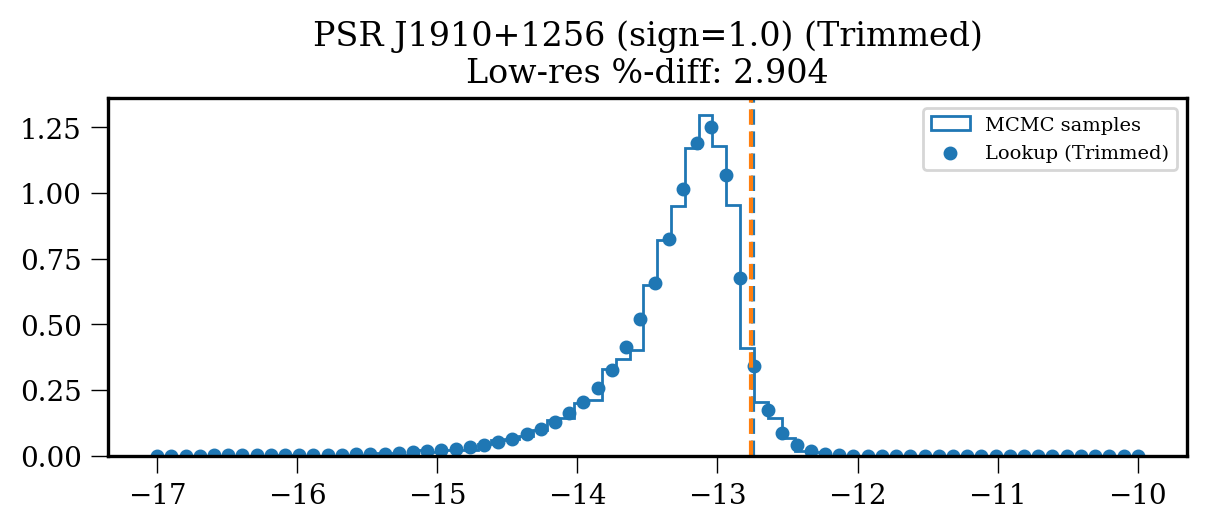

not looking for bursts between MJD 53472.06272390708 and MJD 53798.0


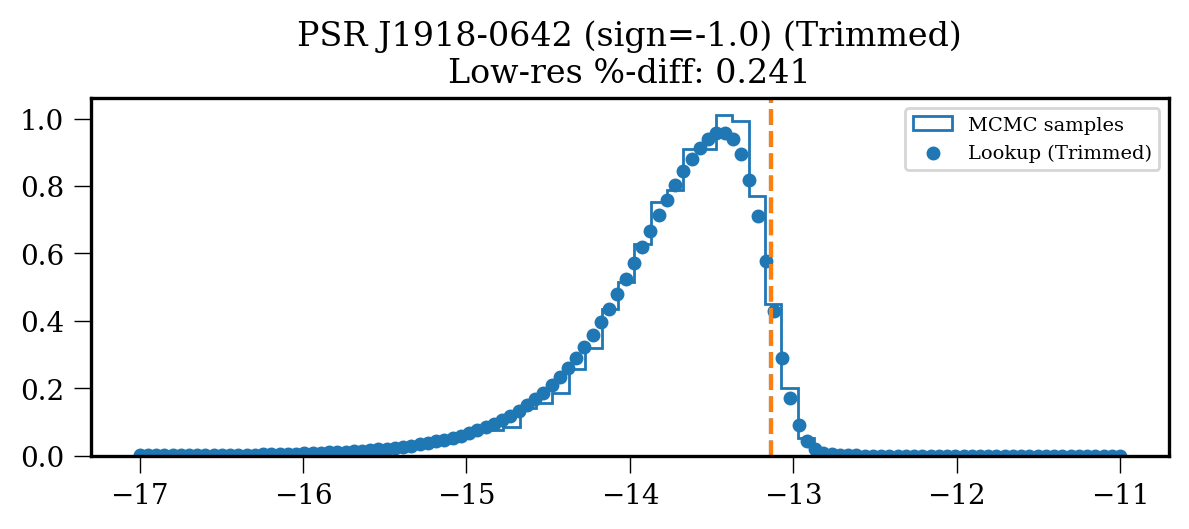

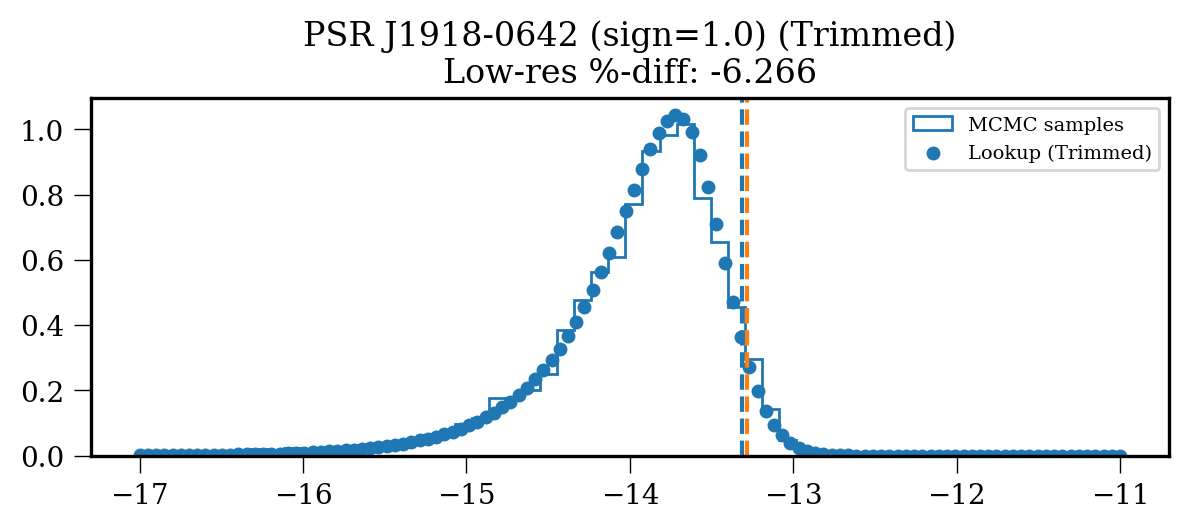

not looking for bursts between MJD 55971.099767191066 and MJD 55934.0


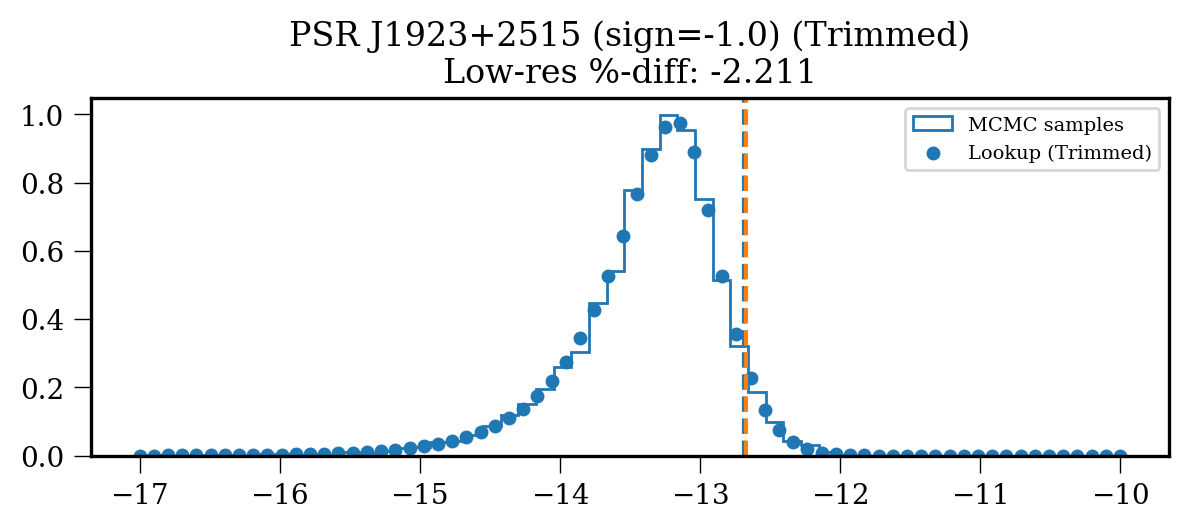

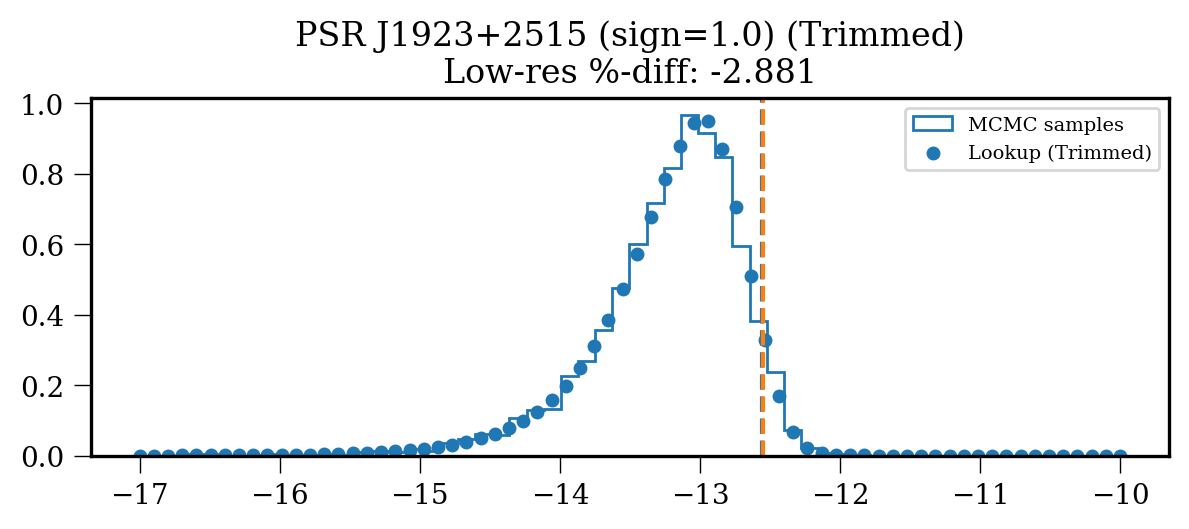

not looking for bursts between MJD 55940.18531116101 and MJD 55876.0


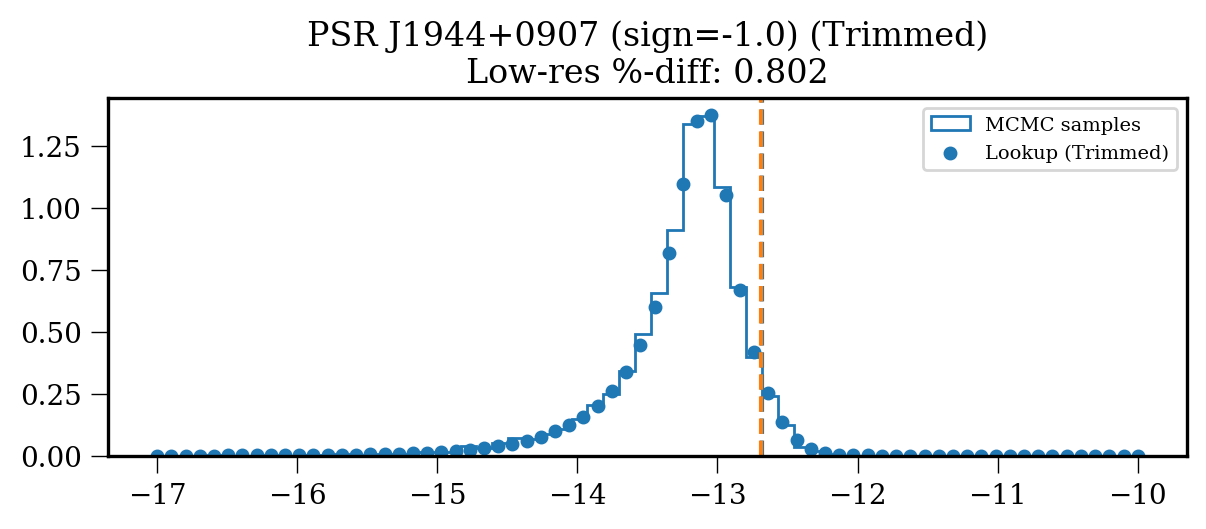

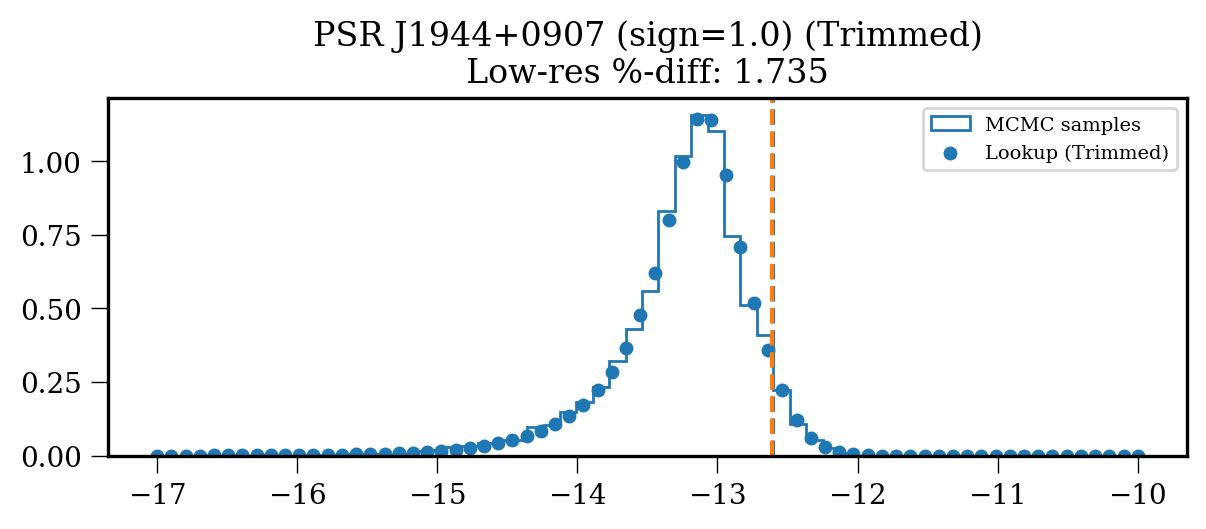

not looking for bursts between MJD 55274.89460089244 and MJD 55243.0


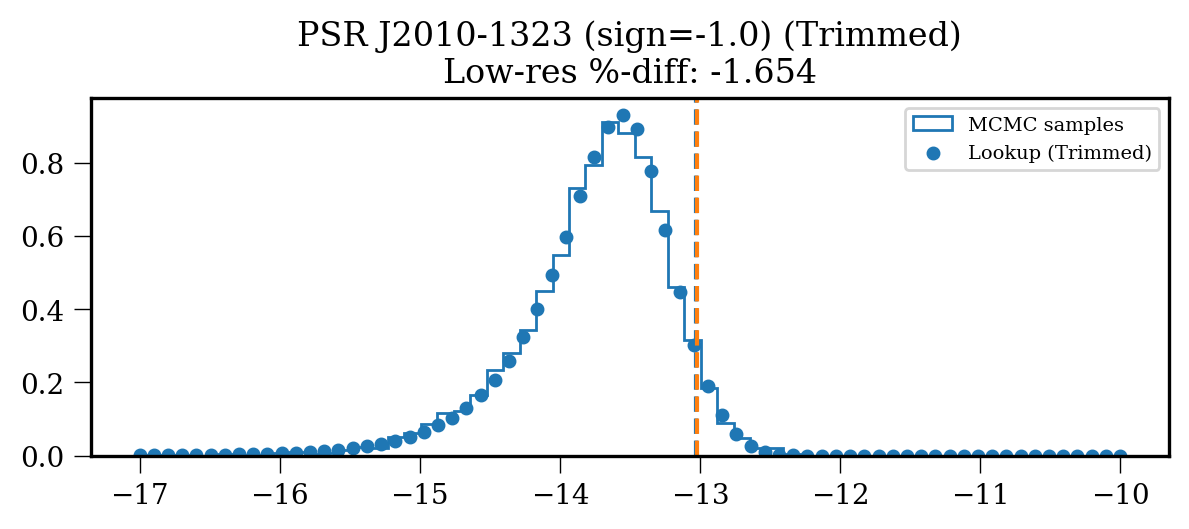

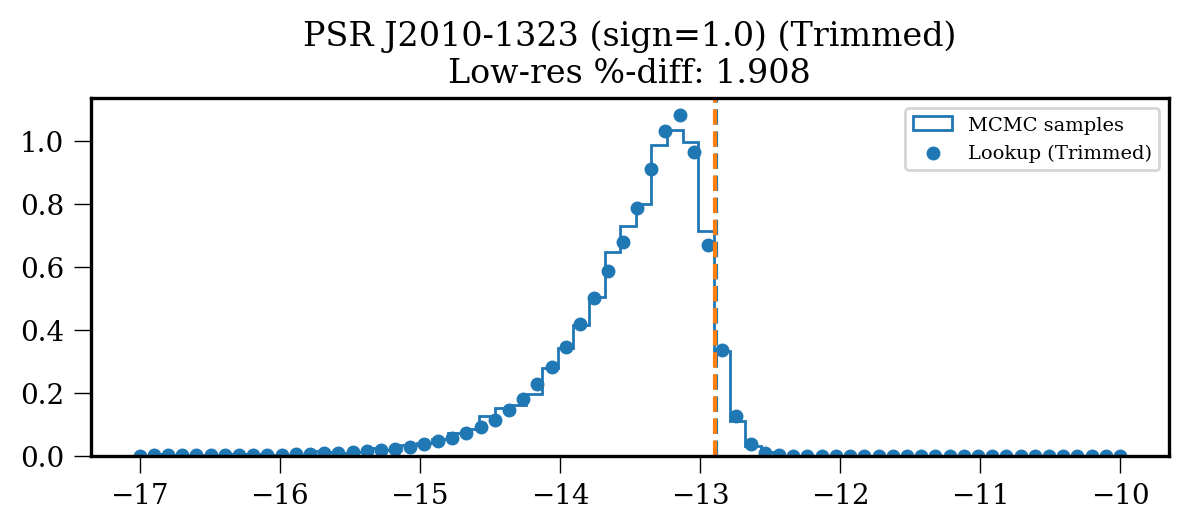

not looking for bursts between MJD 56169.6174466498 and MJD 56188.0


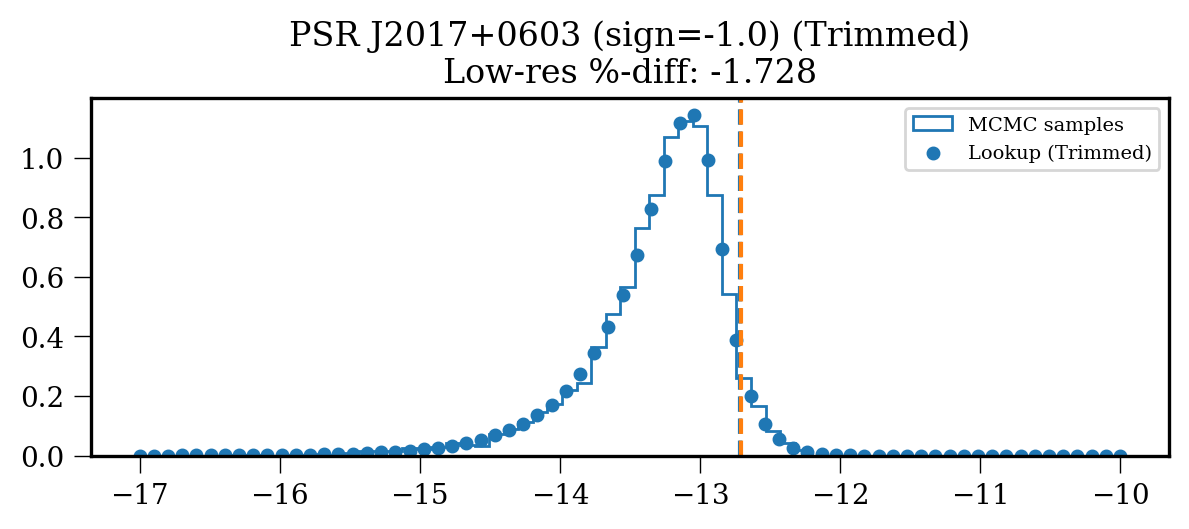

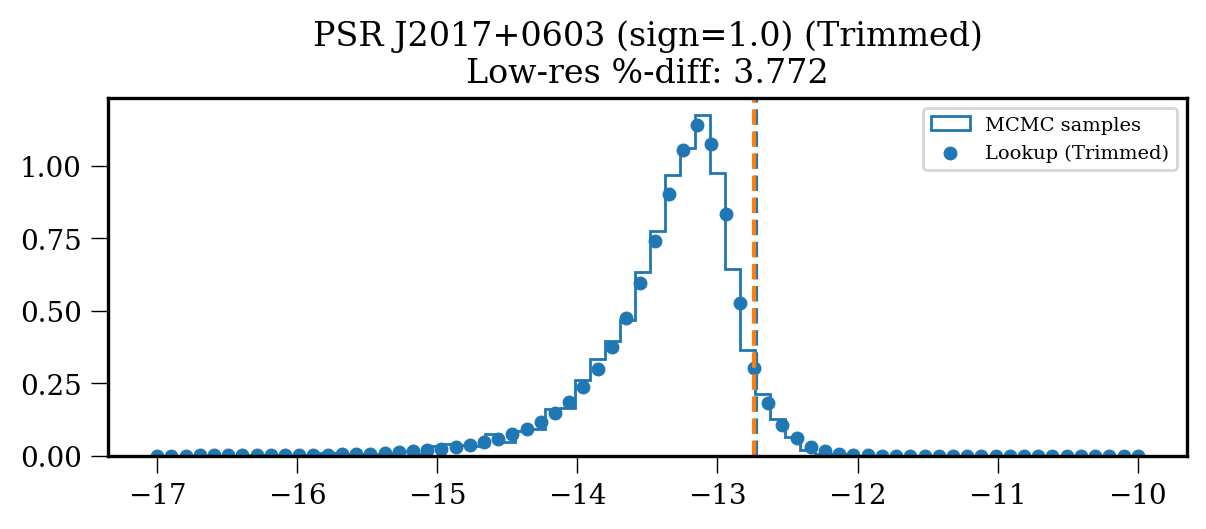

not looking for bursts between MJD 55938.24522573382 and MJD 55850.0


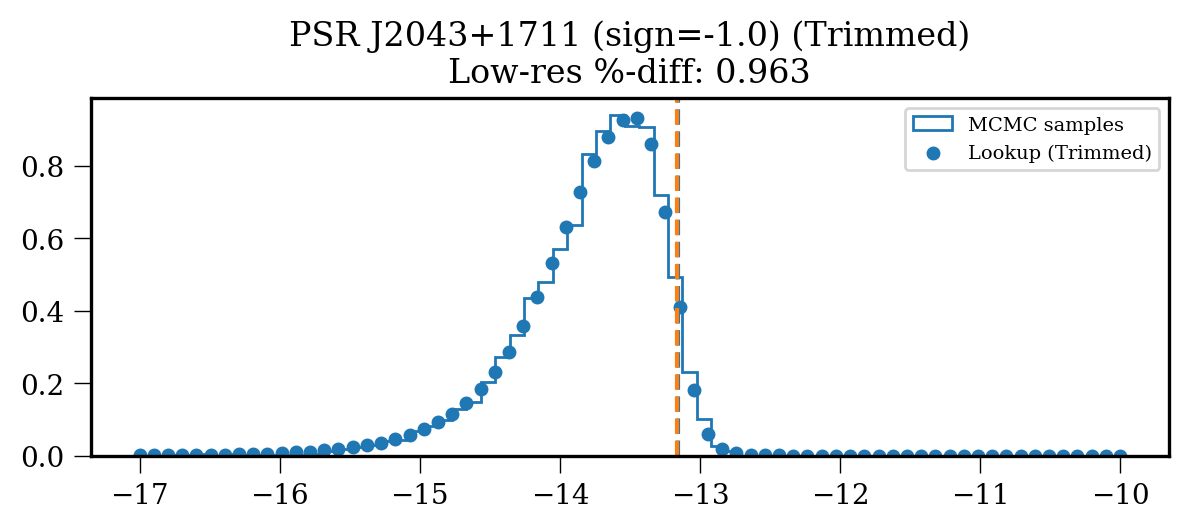

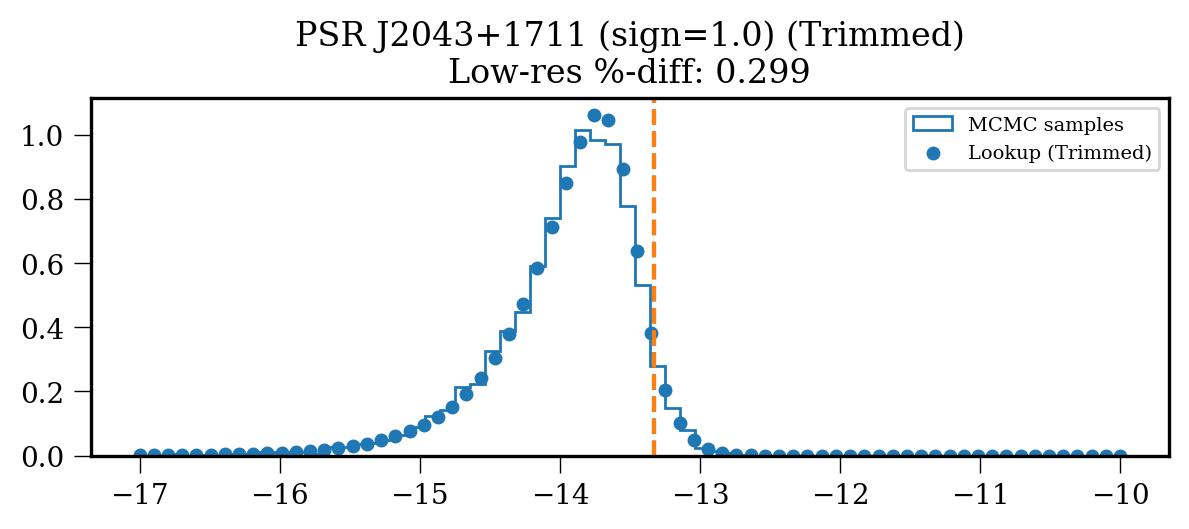

not looking for bursts between MJD 53447.18898525151 and MJD 53355.0


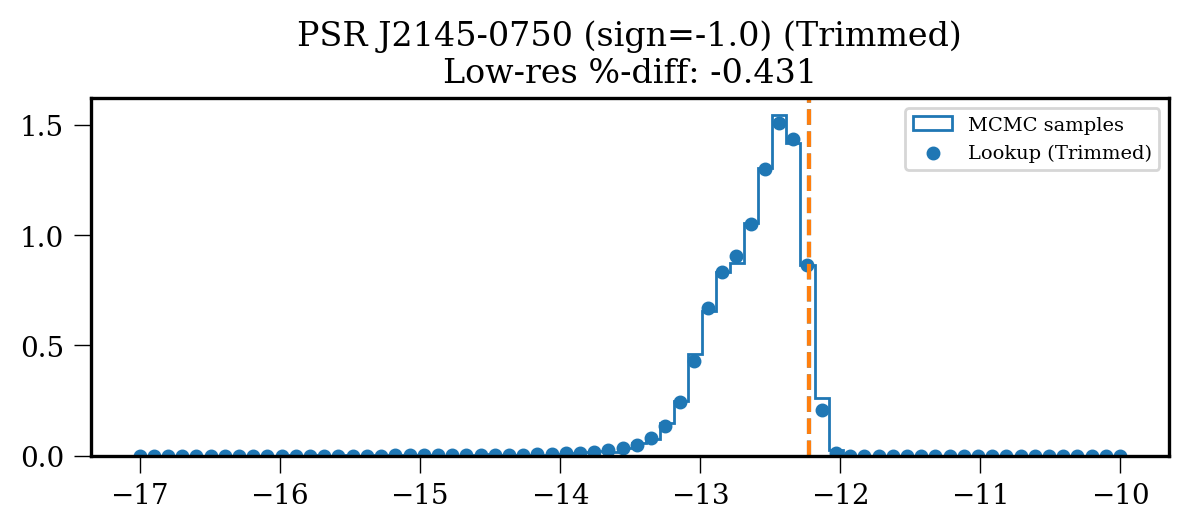

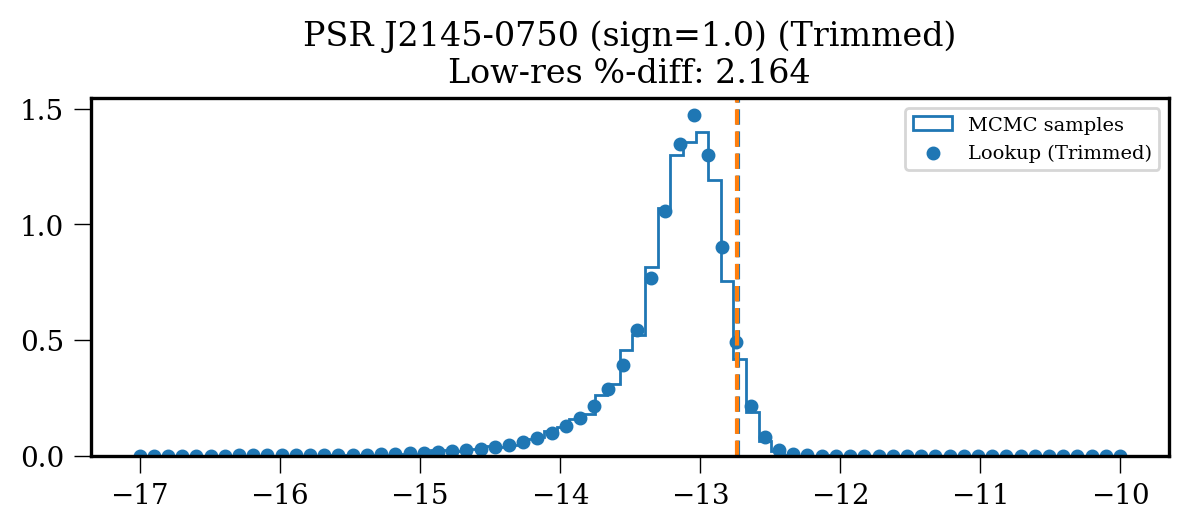

not looking for bursts between MJD 56024.065253192784 and MJD 56023.0


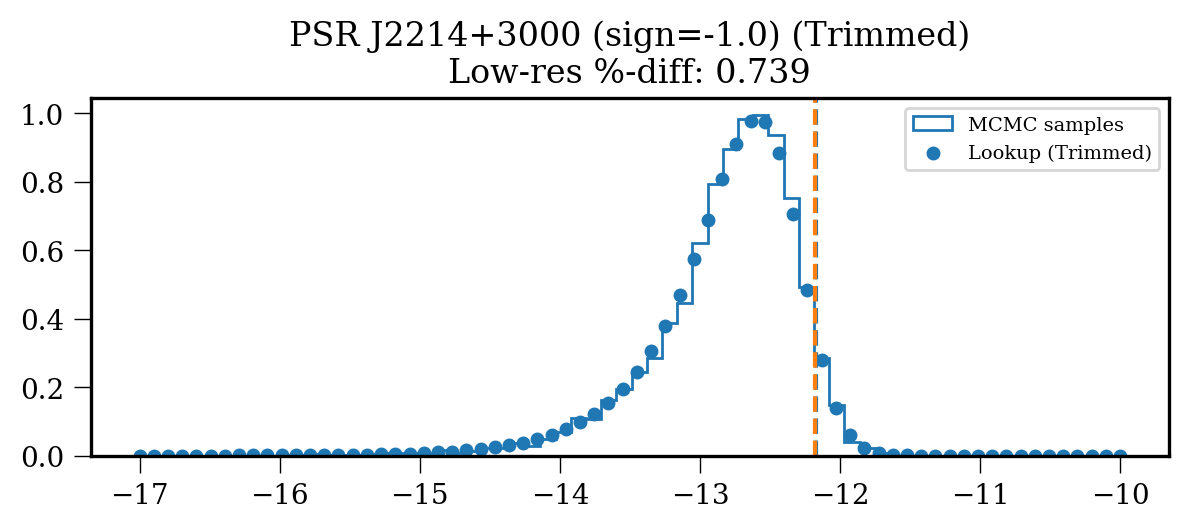

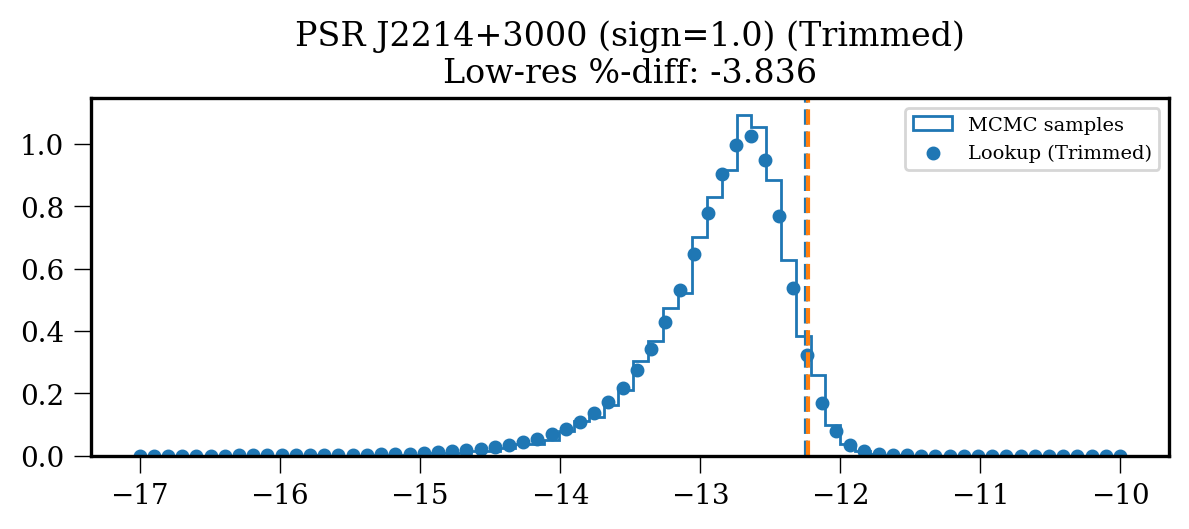

not looking for bursts between MJD 56152.06009158026 and MJD 56149.0


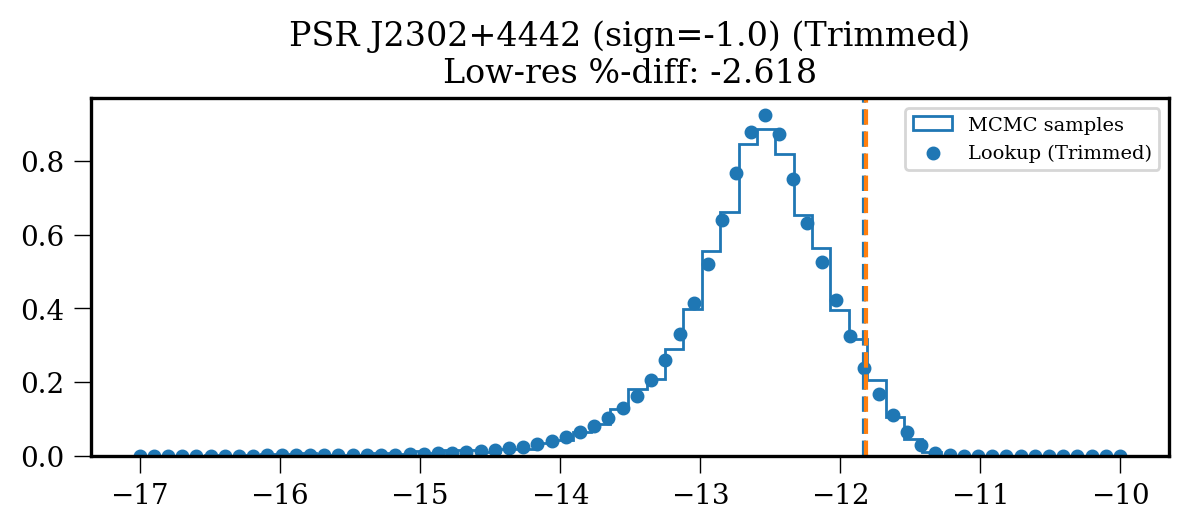

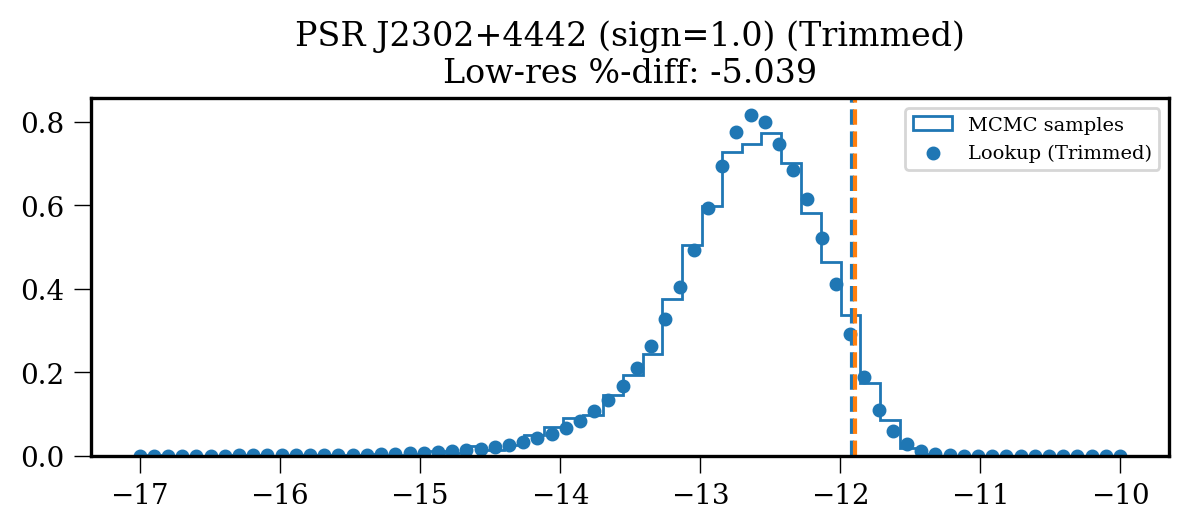

not looking for bursts between MJD 53535.93464870485 and MJD 53357.0


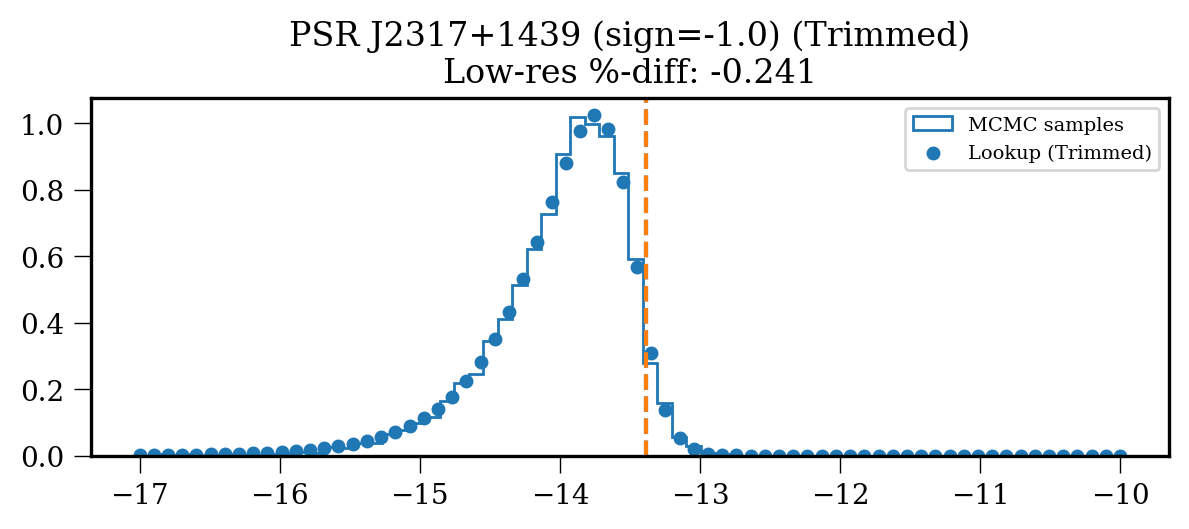

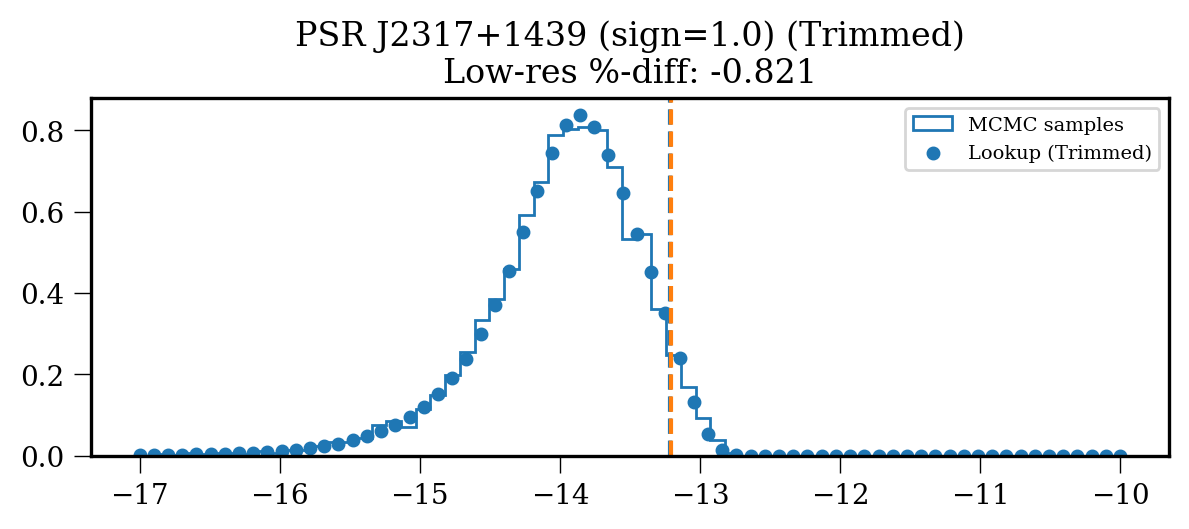

In [102]:
psr_ul_diffs = {}
for psr in allpsrs:
    psr_ul_diffs[psr.name] = resample_worker(psr)

In [103]:
psr_ul_diffs

{'B1855+09': {-1.0: 0.7223197122393551, 1.0: 1.3433135373029164},
 'B1937+21': {-1.0: -1.425921035810548, 1.0: -2.161591507882738},
 'B1953+29': {-1.0: 2.491663279998085, 1.0: -5.896467781695503},
 'J0023+0923': {-1.0: -2.7199389136797034, 1.0: 1.920238393512411},
 'J0030+0451': {-1.0: -0.14577244034578457, 1.0: 1.1906254689126787},
 'J0340+4130': {-1.0: -2.9383881934720613, 1.0: 0.28615221107753475},
 'J0613-0200': {-1.0: -0.36472350178844987, 1.0: 3.987144780448677},
 'J0645+5158': {-1.0: 2.228997845035798, 1.0: -2.272773321719492},
 'J1012+5307': {-1.0: 0.490681201043762, 1.0: 0.07875283063594822},
 'J1024-0719': {-1.0: -2.6344664849980526, 1.0: -0.7732600899527478},
 'J1455-3330': {-1.0: 0.45670042502235975, 1.0: 9.467533507910522},
 'J1600-3053': {-1.0: 5.964790707740999, 1.0: 8.567953867247319},
 'J1614-2230': {-1.0: 1.0982423997485673, 1.0: 3.1289430800377933},
 'J1640+2224': {-1.0: -0.31622432190029226, 1.0: 4.70999529667187},
 'J1643-1224': {-1.0: 0.10344210113610947, 1.0: 4.4

In [ ]:
pool = mp.Pool(processes=10)
pool.map(resample_worker, allpsrs)

In [ ]:
# let's just compare the resulting samples
for psr in allpsrs:
    high_res_lookupdir = '/home/nima/nanograv/11yr_factlike/lookup_tables_highres/{}/'.format(psr.name)
    low_res_lookupdir = '/home/nima/nanograv/11yr_factlike/lookup_tables_final/{}/'.format(psr.name)
    bayesian_chaindir = '/home/nima/nanograv/11yr_factlike/bayesian_verification/individual_pulsars_fixed_sign/'
    
    for sign in [-1, 1]:
        # need to do 3 things:
        # -resample high res lookup
        # -resample low res lookup
        # -plot bayesian 
        #resampled_highres = lookup_resampler_choose(psr, highres=True)
        
        resampled_lowres = lookup_resampler_choose(psr, highres=False)
        
        highres_ul95 = resampled_highres[int(0.95 * len(resampled_highres))]
        lowres_ul95 = resampled_highres[int(0.95 * len(resampled_lowres))]
        
        
        chaindir = '/home/nima/nanograv/11yr_factlike/bayesian_verification/individual_pulsars_fixed_sign/{}_{}/'.format(psr.name, sign)
        core = Core(label='', chaindir = chaindir)
        mcmc_samples = sorted(core.get_param('{}_ramp_log10_A'.format(psr.name)))
        mcmc_ul95 = mcmc_samples[int(0.95 * len(mcmc_samples))]
        
        
        n, bins, patches = plt.hist(resampled_highres, histtype='step',label='Lookup High Res', density=True, bins=30)
        plt.hist(resampled_lowres, histtype='step',label='Lookup Low Res', density=True, bins=bins)
        plt.hist(mcmc_samples, histtype='step', label='MCMC samples', density=True, bins=bins)
        
        plt.axvline(x=highres_ul95, ls='--', color = 'tab:blue')
        plt.axvline(x=lowres_ul95, ls='--', color = 'tab:orange')
        plt.axvline(x=mcmc_ul95, ls='--', color = 'tab:green')
        
        plt.legend()
        plt.title("PSR {} (sign={})".format(psr.name, sign))
        plt.show()
        
        highres_pctdiff = 100*(10**highres_ul95 - 10**mcmc_ul95)/(10**mcmc_ul95) 
        lowres_pctdiff = 100*(10**lowres_ul95 - 10**mcmc_ul95)/(10**mcmc_ul95) 
        print('PSR {}, sign {} ======================================================='.format(psr.name, sign))
        print('High-res %-diff: {:.03f}\nLow-res %-diff: {:.03f}'.format(highres_pctdiff, lowres_pctdiff))

In [ ]:
import corner

for psr in test_psrs:
    for sign in [-1,1]:
        mcmc_chaindir = '/home/nima/nanograv/11yr_factlike/bayesian_verification/individual_pulsars_fixed_sign/{}_{}/'.format(psr.name, sign)
        core = Core(label='', chaindir = mcmc_chaindir, )
        plot_chains(core,hist=True,linestyle='--', 
                    pars=['{}_ramp_log10_A'.format(psr.name), 'ramp_t0'.format(psr.name), '{}_red_noise_gamma'.format(psr.name), '{}_red_noise_log10_A'.format(psr.name)], 
                    suptitle='PSR {}, sign={}'.format(psr.name, sign), ncols=2, title_y=1.03)
        
        # Let's also make corner plots
        epochs = core.get_param('ramp_t0')
        amps = core.get_param('{}_ramp_log10_A'.format(psr.name))
        
        samples = []
        for el in epochs:
            samples.append(el)
        for el in amps:
            samples.append(el)
        samples = np.array(samples)
        samples = samples.reshape((len(amps),2), order='F')
        
        corner.corner(samples, labels=['ramp_t0','{}_ramp_log10_A'.format(psr.name)],plot_contours=True, levels=[0.25, 0.5, 0.75, 0.9])

# Final UL comparison plot

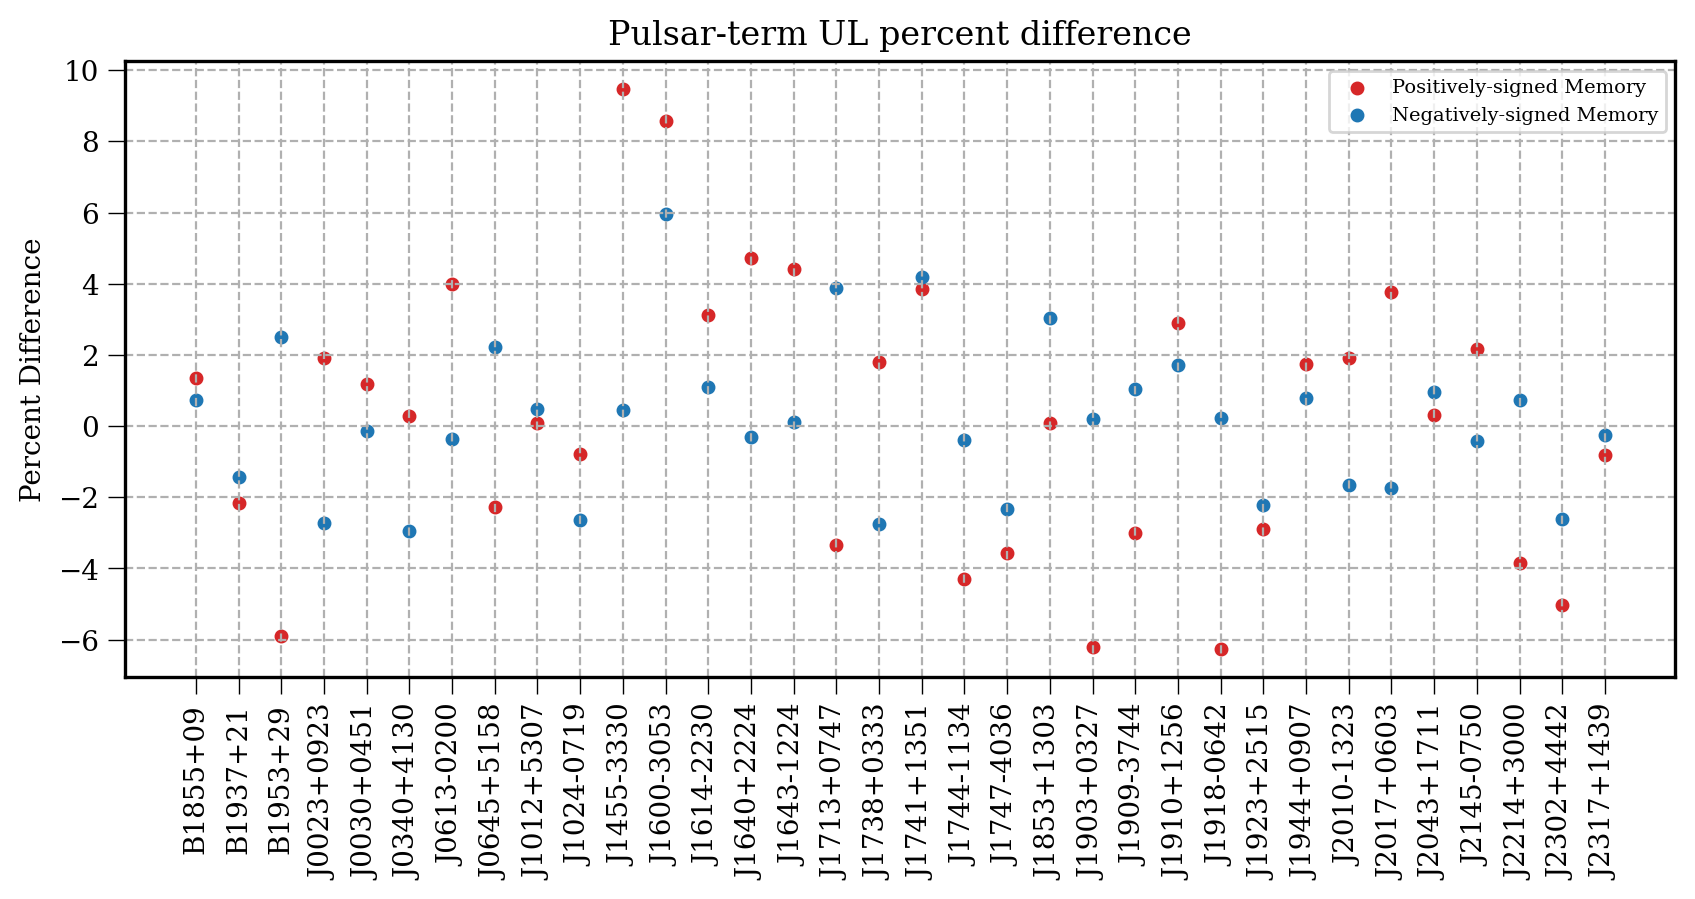

In [118]:
fig, ax = plt.subplots(figsize=(10,4))
pos_diffs = [psr_ul_diffs[p.name][1] for p in allpsrs]
neg_diffs = [psr_ul_diffs[p.name][-1] for p in allpsrs]
ax.scatter(np.arange(len(pos_diffs)), pos_diffs, c='tab:red', label='Positively-signed Memory')
ax.scatter(np.arange(len(neg_diffs)), neg_diffs, c='tab:blue', label='Negatively-signed Memory')
plt.legend()
ax.set_xticks(np.arange(len(allpsrs)))
ax.set_xticklabels([p.name for p in allpsrs], rotation=90)
ax.set_ylabel('Percent Difference')
plt.title("Pulsar-term UL percent difference")
ax.grid(b=True,ls='--')

In [ ]:
ax.scatter(pos_diffs, )

# Check on order of parameters of PTA

In [77]:
from __future__ import division

import numpy as np
import os, glob, json
import matplotlib.pyplot as plt
import pickle
import scipy.linalg as sl
import scipy.integrate as spint
import healpy as hp
import multiprocessing as mp
import math

os.environ["TEMPO2"]='/home/nima/.local/share/tempo2/'

from enterprise.signals import parameter
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals import utils
from enterprise.signals import gp_signals
from enterprise import constants as const
from enterprise.signals.signal_base import LogLikelihood
from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import sampler as ee_sampler
from enterprise_extensions import blocks as ee_blocks
from enterprise_extensions import deterministic

from la_forge.core import Core, load_Core
from la_forge import rednoise
from la_forge.diagnostics import plot_chains

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Do not have acor package


In [78]:
psr = allpsrs[0]

fullpta_tmax = max([max(p.toas) for p in allpsrs])
fullpta_tmin = min([min(p.toas) for p in allpsrs])
full_12p5_tspan_sec = fullpta_tmax-fullpta_tmin
full_12p5_tspan_mjd = full_12p5_tspan_sec/24/3600

In [84]:
U,_ = utils.create_quantization_matrix(psr.toas, dt=7)
eps = 9  # clip first and last N observing epochs

tmin_mjd = np.floor(max(U[:,eps] * psr.toas/24/3600))
tmax_mjd = np.ceil(max(U[:,-eps] * psr.toas/24/3600))


Tspan_sec = (tmax_mjd-tmin_mjd) * 24 * 3600
Tspan_mjd = tmax_mjd - tmin_mjd

log10_rn_amps = np.linspace(-17, -11, 60)
log10_bwm_amps = np.linspace(-17, -10, 70)
log10_crn_amps = np.linspace(-16, -14, 20)


print("Tspan_sec: {}".format(Tspan_sec))
IRN_logmin = min(log10_rn_amps)
IRN_logmax = max(log10_rn_amps)

CRN_logmin = min(log10_crn_amps)
CRN_logmax = max(log10_crn_amps)

bwm_logmin = min(log10_bwm_amps)
bwm_logmax = max(log10_bwm_amps)

#Intrinsic Red Noise
s = ee_blocks.red_noise_block(psd='powerlaw', prior='log-uniform', components=30,
                                 logmin=IRN_logmin, logmax=IRN_logmax, Tspan=None)
# Jury is still out on which Tspan to use
# I think this needs to reflect what the Tspan will be at runtime
# which ought to be the Tspan of the entire PTA, even if it overparameterizes
# the individual PTA Tspan.
#print("creating cRN with tspan = {}".format(full_12p5_tspan_sec))
# s += ee_blocks.common_red_noise_block(psd='powerlaw', prior='log-uniform',
#                                     Tspan=full_12p5_tspan_sec, components=30, gamma_val=13./3.,
#                                     logmin=CRN_logmin, logmax=CRN_logmax)


# Add a ramp to the data
print("creating ramp block with tmax, tmin: {} , {}\n and amplitudes {} , {}".format(tmin_mjd, tmax_mjd, bwm_logmin, bwm_logmax))
s += ee_blocks.bwm_sglpsr_block(Tmin=tmin_mjd, Tmax=tmax_mjd, amp_prior='log-uniform',
                             logmin=bwm_logmin, logmax=bwm_logmax,
                             fixed_sign=None)

# Common Red Noise
# Based on results from 12p5, looks like the 13/3 process is well constrained





s += ee_blocks.common_red_noise_block(psd='powerlaw', prior='uniform',
                                        Tspan=full_12p5_tspan_sec, components=5,
                                     logmin = CRN_logmin, logmax=CRN_logmax, gamma_val=13./3., name='gw')

s += gp_signals.TimingModel()

if 'NANOGrav' in psr.flags['pta']:
    s += ee_blocks.white_noise_block(vary=False, inc_ecorr=True)
else:
    s += ee_blocks.white_noise_block(vary=False, inc_ecorr=False)

models = []
models.append(s(psr))

pta = signal_base.PTA(models)

Tspan_sec: 329788800.0
creating ramp block with tmax, tmin: 53448.0 , 57265.0
 and amplitudes -17.0 , -10.0


In [85]:
pta.params

[B1855+09_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1855+09_red_noise_log10_A:Uniform(pmin=-17.0, pmax=-11.0),
 gw_log10_A:LinearExp(pmin=-16.0, pmax=-14.0),
 ramp_log10_A:Uniform(pmin=-17.0, pmax=-10.0),
 ramp_t0:Uniform(pmin=53448.0, pmax=57265.0),
 sign:Uniform(pmin=-1, pmax=1)]